# FASE 7

## Preparación y Entrenamiento de la RNN (LSTM / GRU)

### 1️⃣ Datos
- Dataset final: `../../data/processed/final_features_list.csv.gz`  
- Dimensiones: ~44.630 filas × 90 columnas  
- Rango temporal: **2005-01-01 → 2025-10-31**  
- La serie debe reflejar **exactamente la evolución real de la bolsa**  
- Variables principales: precios y retornos de BBVA y Santander + componentes PCA  



### 2️⃣ Modelado
- Modelos a probar: **LSTM** y **GRU**, comparar desempeño  
- Predicción **corto plazo**: 1 a 5 días adelante  
- Entrada principal: **t-1** (opcional incluir t-2, t-3… para patrones más largos)  
- Considerar **descomposición de la serie** (tendencia / estacionalidad / residual)  

### 3️⃣ Preprocesamiento
- Normalización de datos (z-score o min-max) por ventana de entrenamiento  
- Forward-fill / backward-fill para huecos temporales, sin alterar la curva de la serie  
- Opcional: detrending o trabajar solo con la serie residual  
- Preparar secuencias de entrada (`X`) y salida (`y`) para la RNN  

### 4️⃣ Entrenamiento
- Optimizadores: **Adam** o **descenso de gradiente clásico**  
- **Early stopping** para evitar gradientes explosivos o demasiado pequeños  
- Fijar **semilla** para reproducibilidad  
- **Gradient clipping** para evitar explosión de gradientes  
- Posible uso de **scheduler de learning rate**  
- Monitorear métricas: **logloss, accuracy, RMSE, MAPE**  
- Medir y printear **tiempo por epoch y métricas**  
- Visualización de curvas de pérdida y precisión  

### 5️⃣ Validación
- División temporal: **train / validation / test**  
- Validar predicciones en ventanas cortas y por eventos macroeconómicos  
- Predicción **single-step** vs **multi-step** (iterativa o directa)  
- Graficar predicciones vs real, especialmente en picos, crisis y shocks  

### 6️⃣ Experimentación
- Iterar **hiperparámetros**: tamaño de la RNN, número de capas, dropout, learning rate, batch size  
- Decidir si usar **GPU** para acelerar entrenamiento  



### 7️⃣ Notas adicionales
- Mantener consistencia temporal en la normalización y splits  
- Todas las decisiones de imputación o relleno deben preservar la integridad de la curva de mercado  
- Preparar el set final de features (`top_features + PCA components`) listo para RNN  

---


## Plan de Notebook 



### **Parte 1 — Configuración Inicial y Carga de Datos**

**Objetivos:**
- Cargar el dataset final (`final_features_list.csv.gz`)  
- Filtrar por rango temporal 2005–2025  
- Fijar semilla para reproducibilidad  
- Seleccionar columnas principales (BBVA, Santander y PCA)  

**Consideraciones:**
- Mantener la curva de la bolsa **exactamente igual**  
- Dataset ~44.630 × 90 columnas  
- Forward/backward fill solo si hay huecos, sin alterar la serie  



### **Parte 2 — Preprocesamiento y Normalización**

**Objetivos:**
- Escalar variables (z-score o min-max por ventana de entrenamiento)  
- Forward-fill / backward-fill de valores faltantes  
- Opcional: detrending o trabajar con la serie residual  
- Crear features de lag: t-1 (y opcional t-2, t-3…)  
- Preparar `X` y `y` para predicción 1–5 días adelante  
- Guardar set listo para train/validation/test  

**Notas importantes:**
- Mantener integridad temporal  
- No rellenar con medias globales si hay eventos significativos  

### **Parte 3 — División Temporal y Secuencias**

**Objetivos:**
- Dividir en train / validation / test por fechas  
- Crear secuencias deslizantes (`t-1 → t-n`) para la RNN  
- Manejar batchs y padding si hay huecos  
- Preparar secuencias para multi-step prediction (1–5 días)  

**Notas:**
- Validación estrictamente temporal (no shuffle)  
- Mantener consistencia con la curva real de mercado  

### **Parte 4 — Definición del Modelo**

**Objetivos:**
- Definir **LSTM y GRU**  
- Ajustar hiperparámetros: capas, unidades, dropout  
- Optimizador: Adam o SGD  
- Loss function: MSE o RMSE  
- Gradient clipping y early stopping  
- Configurar GPU si disponible  

**Notas:**
- Monitorear logloss, accuracy, RMSE, MAPE  
- Guardar la arquitectura y pesos para comparaciones  

### **Parte 5 — Entrenamiento**

**Objetivos:**
- Entrenar modelo por epochs  
- Mostrar **tiempo por epoch**  
- Imprimir métricas de cada epoch  
- Early stopping basado en validation loss  
- Usar scheduler de learning rate si se estanca  

**Notas:**
- Guardar curvas de loss y accuracy  
- Guardar modelo final entrenado  

### **Parte 6 — Validación y Evaluación**

**Objetivos:**
- Graficar predicciones vs real  
- Comparar single-step vs multi-step  
- Analizar picos, crisis y shocks macroeconómicos  
- Calcular métricas financieras: RMSE, MAPE, Sharpe ratio simulado  

**Notas:**
- Evaluar desempeño por ventanas de 1–5 días  
- Revisar que la predicción siga la curva de mercado exactamente  

### **Parte 7 — Experimentación y Hiperparámetros**

**Objetivos:**
- Iterar sobre unidades, capas, dropout, learning rate, batch size  
- Comparar LSTM vs GRU  
- Analizar resultados por cada combinación de hiperparámetros  
- Preparar conclusiones sobre la mejor configuración  

**Notas:**
- Registrar todos los experimentos y métricas  
- Decidir si usar GPU para acelerar experimentación  


## Código

In [112]:
# ==============================
# Liberries
# ==============================
import pandas as pd
import numpy as np
import random
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import time

In [113]:
# ==============================
# PARTE 1 — Configuración Inicial y Carga de Datos
# ==============================

# ------------------------------
# 1. Fijar semilla para reproducibilidad
# ------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------
# 2. Cargar dataset final y poner 'Date' como índice
# ------------------------------
data_path = "../../data/processed/final_data.csv.gz"
data = pd.read_csv(data_path, compression='gzip', parse_dates=['Date'], index_col='Date')

print("Columnas del dataset:", list(data.columns))
print(f"Dimensiones dataset original: {data.shape}")

# ------------------------------
# 3. Filtrar rango temporal
# ------------------------------
start_date = "2005-01-01"
end_date = "2025-10-31"
data = data.loc[start_date:end_date]

print(f"Dimensiones dataset filtrado 2005-2025: {data.shape}")

# ------------------------------
# 4. Seleccionar columnas principales
# ------------------------------
# Columnas de interés para la RNN: precios BBVA, Santander y PCA
pca_cols = [col for col in data.columns if "PCA" in col]
main_cols = ['BBVA.MC_Close', 'SAN.MC_Close'] + pca_cols

data_rnn = data[main_cols]
print(f"Columnas seleccionadas para la RNN: {data_rnn.shape[1]}")

# ------------------------------
# 5. Visualización rápida
# ------------------------------
display(data_rnn)

Columnas del dataset: ['SAN.MC_Close', 'BKT.MC_Low', 'STOXX50E_Low', 'STOXX50E_Open', 'HSBC_Low', 'UNI.MC_Open', 'HSBC_Open', 'EURJPY.csv_Close', 'ECB_M3_SKK', 'IBEX_High', 'BBVA.MC_Low', 'MSCI_Financials.csv_High', 'IBEX_Close', 'SAB.MC_Low', 'UNI.MC_Low', 'EURJPY.csv_Open', 'UNI.MC_High', 'GDAXI_Close', 'URTH_Low', 'URTH_Close', 'GDAXI_Open', 'STOXX50E_Close', 'STOXX50E_High', 'BBVA.MC_Open', 'BKT.MC_Open', 'N225_Open', 'ECB_M3_HKD', 'FTSE_Close', 'EURJPY.csv_Low', 'FTSE_Low', 'UNI.MC_Close', 'JPM_Open', 'IBEX_Low', 'BKT.MC_Close', 'URTH_Open', 'HSBC_Close', 'ECB_M3_USD', 'GDAXI_Low', 'GDAXI_High', 'CABK.MC_Close', 'JPM_Close', 'SAB.MC_Close', 'SAB.MC_High', 'JPM_High', 'SAN.MC_Low', 'MSCI_Financials.csv_Open', 'FTSE_Open', 'BBVA.MC_Close', 'ECB_M3_CZK', 'FTSE_High', 'BBVA.MC_High', 'BKT.MC_High', 'EURJPY.csv_High', 'N225_High', 'SAN.MC_Open', 'MSCI_Financials.csv_Close', 'MSCI_Financials.csv_Low', 'N225_Close', 'URTH_High', 'IBEX_Open', 'ECB_M3_JPY', 'CABK.MC_High', 'CABK.MC_Open', 

,BBVA.MC_Close,SAN.MC_Close,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,-1.826990,9.380348,-1.741290,3.502204,-0.836790,3.841229,-5.521703,-1.800316,...,0.557657,0.282267,-0.342419,0.156220,-0.129392,0.314089,-0.252011,-1.024318,0.424503,-0.375780
2005-01-02,NaN,NaN,-1.829039,9.372219,-1.740167,3.499036,-0.836139,3.838251,-5.517482,-1.798937,...,0.556834,0.281893,-0.341843,0.155771,-0.129330,0.313644,-0.251855,-1.022809,0.423520,-0.375943
2005-01-03,4.446411,2.599646,13.872782,11.112143,-3.493010,-2.724641,0.472894,-2.873407,-4.582791,1.332656,...,2.515268,1.295396,-1.021902,0.445984,0.216710,-0.171002,0.269162,0.382764,0.353047,-0.440628
2005-01-04,4.422707,2.599646,14.893037,11.396897,-3.324143,-4.069852,0.663474,-2.580715,-5.022860,2.046954,...,1.853438,1.007899,-1.303535,-1.117715,1.556725,-1.142550,0.401012,0.559087,-0.074189,0.690906
2005-01-05,4.399001,2.562912,14.396275,11.309068,-3.677995,-3.095892,0.531848,-2.974937,-4.570563,1.700930,...,2.607476,1.358329,-1.250671,0.216616,0.716502,-0.387861,0.256955,0.455559,0.370632,-0.141541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,17.580000,8.865000,28.104901,-13.234004,-7.846998,9.143141,-0.996252,-5.593029,1.942455,-4.821068,...,-1.417439,0.270332,-0.035416,-3.233211,3.800043,-1.273700,1.316176,-4.846464,-0.938750,-0.844075
2025-10-30,17.280001,8.750000,27.821980,-12.739586,-7.443427,8.330550,-0.781672,-5.817917,1.940370,-5.307145,...,-0.837936,0.501435,0.858817,-5.682608,0.919306,0.624927,0.554233,-4.628295,-0.080748,-0.642446
2025-10-30,17.280001,8.750000,27.762862,-12.795248,-7.422621,8.325187,-0.777465,-5.887823,1.912897,-5.162755,...,-0.739295,0.549786,0.778913,-5.656696,0.947402,0.721576,0.793313,-4.729327,-0.076427,-0.544759


In [114]:
# ==============================
# PARTE 2 — Preprocesamiento y Preparación de Secuencias (TF)
# ==============================

# ------------------------------
# 1. Forward-fill / Backward-fill por si hay NaN
# ------------------------------
data_rnn = data_rnn.ffill().bfill()

# ------------------------------
# 2. Escalado de datos
# ------------------------------
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_rnn), 
                           columns=data_rnn.columns, index=data_rnn.index)

# ------------------------------
# 3. Función para crear secuencias
# ------------------------------
def create_sequences(data, target_cols=['BBVA.MC_Close', 'SAN.MC_Close'], 
                     lookback=5, horizon=1):
    X, y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X_seq = data.iloc[i - lookback:i].values
        y_seq = data.iloc[i:i + horizon][target_cols].values  # multi-step support
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# ------------------------------
# 4. Crear secuencias para single-step y multi-step
# ------------------------------
lookback = 5  # t-1 a t-5

# Single-step (1 día adelante)
horizon = 1
X_1, y_1 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# Multi-step (5 días adelante)
horizon = 5
X_5, y_5 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# ------------------------------
# 5. Información de shapes
# ------------------------------
print("Single-step prediction:")
print("X_1.shape:", X_1.shape)  # (samples, 5, n_features)
print("y_1.shape:", y_1.shape)  # (samples, 1, target_cols)

print("\nMulti-step prediction (5 días):")
print("X_5.shape:", X_5.shape)
print("y_5.shape:", y_5.shape)

# ------------------------------
# Crear vector de fechas correspondiente a cada secuencia
# ------------------------------
dates_all_1 = data_scaled.index[lookback : len(data_scaled) - 1 + 1]  # para X_1, single-step
dates_all_5 = data_scaled.index[lookback : len(data_scaled) - 5 + 1]  # para X_5, multi-step 5 días


Single-step prediction:
X_1.shape: (9520, 5, 24)
y_1.shape: (9520, 1, 2)

Multi-step prediction (5 días):
X_5.shape: (9516, 5, 24)
y_5.shape: (9516, 5, 2)


In [101]:
display(data_scaled)

,BBVA.MC_Close,SAN.MC_Close,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,-0.317987,-0.848228,-1.358612,1.034835,-0.799572,0.591331,-0.149875,1.064762,-3.129804,-0.619318,...,0.424398,0.195495,-0.265098,0.057354,0.007225,0.216878,0.060512,-0.802750,0.384390,-0.203940
2005-01-02,-0.317987,-0.848228,-1.358793,1.034010,-0.799317,0.590667,-0.149740,1.063930,-3.127409,-0.618863,...,0.423959,0.195316,-0.264803,0.057127,0.007257,0.216649,0.060607,-0.801809,0.383783,-0.204064
2005-01-03,-0.317987,-0.848228,0.031795,1.210631,-1.197809,-0.714320,0.121685,-0.811318,-2.597119,0.416147,...,1.469783,0.681576,-0.612962,0.203968,0.186518,-0.033172,0.378494,0.074182,0.340327,-0.253016
2005-01-04,-0.326732,-0.848228,0.122151,1.239537,-1.159419,-0.996385,0.161202,-0.729539,-2.846789,0.652227,...,1.116359,0.543640,-0.757146,-0.587227,0.880694,-0.533976,0.458939,0.184072,0.076875,0.603309
2005-01-05,-0.335478,-0.880170,0.078157,1.230621,-1.239864,-0.792164,0.133909,-0.839685,-2.590182,0.537864,...,1.519023,0.711771,-0.730082,0.087913,0.445429,-0.144956,0.371046,0.119550,0.351170,-0.026672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,4.527693,4.599720,1.292224,-1.260770,-2.187647,1.774128,-0.182939,-1.571184,1.104929,-1.617695,...,-0.630324,0.189769,-0.107927,-1.657619,2.042812,-0.601580,1.017306,-3.184816,-0.456249,-0.558338
2025-10-30,4.417007,4.499723,1.267168,-1.210581,-2.095899,1.603743,-0.138446,-1.634019,1.103746,-1.778346,...,-0.320863,0.300648,0.349880,-2.896957,0.550488,0.377105,0.552424,-3.048848,0.072831,-0.405748
2025-10-30,4.417007,4.499723,1.261932,-1.216231,-2.091168,1.602619,-0.137574,-1.653550,1.088160,-1.730624,...,-0.268188,0.323846,0.308973,-2.883846,0.565043,0.426925,0.698293,-3.111813,0.075495,-0.331821


# Pruebas

## Prueba 1

In [30]:
# # ==============================
# # PARTE 3 — Construcción y Entrenamiento de la RNN (LSTM / GRU)
# # ==============================

# import time
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
# from tensorflow.keras.callbacks import Callback, EarlyStopping
# import matplotlib.pyplot as plt

# # ------------------------------
# # 1. Elegir horizonte: single-step o multi-step
# # ------------------------------
# # Para single-step:
# X, y = X_1, y_1
# # Para multi-step (5 días):
# # X, y = X_5, y_5

# # Aplanar y para Keras
# y = y.reshape(y.shape[0], -1)

# input_shape = (X.shape[1], X.shape[2])
# output_size = y.shape[1]

# print(f"Input shape: {input_shape}, Output size: {output_size}")

# # ------------------------------
# # 2. Callback para tiempo por epoch
# # ------------------------------
# class TimeHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.times = []
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_time_start = time.time()
#     def on_epoch_end(self, epoch, logs=None):
#         elapsed = time.time() - self.epoch_time_start
#         self.times.append(elapsed)
#         print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# time_callback = TimeHistory()

# # ------------------------------
# # 3. Función para construir RNN
# # ------------------------------
# def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.2):
#     model = Sequential()
#     if rnn_type == 'LSTM':
#         model.add(LSTM(units, input_shape=input_shape))
#     elif rnn_type == 'GRU':
#         model.add(GRU(units, input_shape=input_shape))
#     else:
#         raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
#     model.add(Dropout(dropout))
#     model.add(Dense(output_size))
    
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     return model

# # ------------------------------
# # 4. Early stopping
# # ------------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # ------------------------------
# # 5. Hiperparámetros a iterar
# # ------------------------------
# rnn_types = ['LSTM', 'GRU']
# units_list = [64, 128]
# dropout_list = [0.2, 0.3]
# batch_sizes = [32, 64]

# histories = {}

# # ------------------------------
# # 6. Entrenamiento iterativo
# # ------------------------------
# for rnn_type in rnn_types:
#     for units in units_list:
#         for dropout in dropout_list:
#             for batch_size in batch_sizes:
#                 name = f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}"
#                 print(f"\n=== Entrenando {name} ===")
                
#                 model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)
                
#                 start_time = time.time()
#                 history = model.fit(
#                     X, y,
#                     validation_split=0.2,
#                     epochs=100,
#                     batch_size=batch_size,
#                     callbacks=[early_stop, time_callback],
#                     verbose=0
#                 )
#                 end_time = time.time()
#                 print(f"Tiempo total entrenamiento {name}: {end_time - start_time:.2f}s")
                
#                 histories[name] = history

# # ------------------------------
# # 7. Graficar métricas
# # ------------------------------
# for key, history in histories.items():
#     plt.figure(figsize=(12,4))
    
#     plt.subplot(1,2,1)
#     plt.plot(history.history['loss'], label='train_loss')
#     plt.plot(history.history['val_loss'], label='val_loss')
#     plt.title(f"{key} - Loss por epoch")
#     plt.legend()
    
#     plt.subplot(1,2,2)
#     plt.plot(history.history['mae'], label='train_mae')
#     plt.plot(history.history['val_mae'], label='val_mae')
#     plt.title(f"{key} - MAE por epoch")
#     plt.legend()
    
#     plt.show()


## Prueba 2

In [31]:
# # ==============================
# # PARTE 3 — Construcción y Entrenamiento de la RNN (LSTM / GRU) Ajustada
# # ==============================

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, Callback
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# import time
# import matplotlib.pyplot as plt

# # ------------------------------
# # Callback para tiempo por epoch
# # ------------------------------
# class TimeHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.times = []
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_time_start = time.time()
#     def on_epoch_end(self, epoch, logs=None):
#         elapsed = time.time() - self.epoch_time_start
#         self.times.append(elapsed)
#         print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# time_callback = TimeHistory()

# # ------------------------------
# # Función para construir RNN ajustada
# # ------------------------------
# def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.3, l2_reg=0.001):
#     model = Sequential()
    
#     if rnn_type == 'LSTM':
#         model.add(LSTM(units, input_shape=input_shape, 
#                        kernel_regularizer=regularizers.l2(l2_reg)))
#     elif rnn_type == 'GRU':
#         model.add(GRU(units, input_shape=input_shape, 
#                       kernel_regularizer=regularizers.l2(l2_reg)))
#     else:
#         raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
    
#     model.add(Dropout(dropout))
#     model.add(Dense(output_size))
    
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # ------------------------------
# # Early stopping más tolerante
# # ------------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# # ------------------------------
# # Selección de hiperparámetros base
# # ------------------------------
# rnn_type = 'LSTM'
# units = 128
# dropout = 0.3
# batch_size = 32

# # ------------------------------
# # Selección de datos (ejemplo single-step, multi-step puedes repetir)
# # ------------------------------
# X_train, y_train = X_1, y_1.reshape(X_1.shape[0], -1)  # single-step aplanado
# # Para multi-step: X_5, y_5.reshape(X_5.shape[0], -1)

# input_shape = (X_train.shape[1], X_train.shape[2])
# output_size = y_train.shape[1]

# # ------------------------------
# # Construir modelo
# # ------------------------------
# model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)

# # ------------------------------
# # Entrenamiento
# # ------------------------------
# start_time = time.time()
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=100,
#     batch_size=batch_size,
#     callbacks=[early_stop, time_callback],
#     verbose=0
# )
# end_time = time.time()
# print(f"Tiempo total entrenamiento: {end_time - start_time:.2f}s")

# # ------------------------------
# # Graficar métricas
# # ------------------------------
# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.title(f"{rnn_type} - Loss por epoch")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(history.history['mae'], label='train_mae')
# plt.plot(history.history['val_mae'], label='val_mae')
# plt.title(f"{rnn_type} - MAE por epoch")
# plt.legend()

# plt.show()


## Prueba 3

In [32]:
# # ==============================
# # ENTRENAMIENTO MULTI-HIPERPARÁMETROS RNN/LSTM
# # ==============================

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, Callback
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# import time
# import itertools
# import pandas as pd

# # ------------------------------
# # Callback para imprimir métricas y tiempo por epoch
# # ------------------------------
# class TimeHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.times = []
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_time_start = time.time()
#     def on_epoch_end(self, epoch, logs=None):
#         elapsed = time.time() - self.epoch_time_start
#         self.times.append(elapsed)
#         print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# # ------------------------------
# # Función para construir RNN
# # ------------------------------
# def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.2, l2_reg=0.001):
#     model = Sequential()
#     if rnn_type == 'LSTM':
#         model.add(LSTM(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
#     elif rnn_type == 'GRU':
#         model.add(GRU(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
#     else:
#         raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
#     model.add(Dropout(dropout))
#     model.add(Dense(output_size))
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # ------------------------------
# # EarlyStopping
# # ------------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# # ------------------------------
# # Hiperparámetros a iterar
# # ------------------------------
# rnn_types = ['LSTM', 'GRU']
# units_list = [64, 128]
# dropouts = [0.2, 0.3]
# batch_sizes = [32, 64]

# # ------------------------------
# # Preparar datos
# # ------------------------------
# # Suponiendo que ya tienes X_train y y_train
# input_shape = (X_train.shape[1], X_train.shape[2])
# output_size = y_train.shape[1]

# # ------------------------------
# # Guardar resultados
# # ------------------------------
# results = []

# # ------------------------------
# # Iterar combinaciones
# # ------------------------------
# for rnn_type, units, dropout, batch_size in itertools.product(rnn_types, units_list, dropouts, batch_sizes):
#     print(f"\n=== Entrenando {rnn_type}_units{units}_drop{dropout}_bs{batch_size} ===")
    
#     model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)
#     time_callback = TimeHistory()
    
#     start_time = time.time()
#     history = model.fit(
#         X_train, y_train,
#         validation_split=0.2,
#         epochs=1000,       # entrenar mucho más
#         batch_size=batch_size,
#         callbacks=[early_stop, time_callback],
#         verbose=0
#     )
#     end_time = time.time()
#     total_time = end_time - start_time
#     print(f"Tiempo total entrenamiento {rnn_type}_units{units}_drop{dropout}_bs{batch_size}: {total_time:.2f}s")
    
#     best_val_loss = min(history.history['val_loss'])
#     best_epoch = history.history['val_loss'].index(best_val_loss) + 1
    
#     # Guardar resultados
#     results.append({
#         'model': f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}",
#         'best_val_loss': best_val_loss,
#         'best_epoch': best_epoch,
#         'history': history,
#         'model_object': model
#     })

# # ------------------------------
# # Mostrar top 5 modelos por val_loss
# # ------------------------------
# results_df = pd.DataFrame(results)
# top5 = results_df.sort_values(by='best_val_loss').head(5)

# print("\n=== TOP 5 MODELOS ===")
# for i, row in top5.iterrows():
#     print(f"{row['model']} - Best val_loss: {row['best_val_loss']:.6f} en epoch {row['best_epoch']}")


## Prueba 4

In [33]:
# # ==============================
# # ENTRENAMIENTO MULTI-HIPERPARÁMETROS RNN/LSTM/GRU
# # ==============================

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, Callback
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# import time
# import itertools
# import pandas as pd
# import matplotlib.pyplot as plt

# # ------------------------------
# # Callback para imprimir métricas y tiempo por epoch
# # ------------------------------
# class TimeHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.times = []
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_time_start = time.time()
#     def on_epoch_end(self, epoch, logs=None):
#         elapsed = time.time() - self.epoch_time_start
#         self.times.append(elapsed)
#         print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - "
#               f"loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - "
#               f"mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# # ------------------------------
# # Función para construir RNN
# # ------------------------------
# def build_rnn(input_shape, output_size, rnn_type='LSTM', units=64, dropout=0.2, l2_reg=0.001):
#     model = Sequential()
#     if rnn_type == 'LSTM':
#         model.add(LSTM(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
#     elif rnn_type == 'GRU':
#         model.add(GRU(units, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)))
#     else:
#         raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
#     model.add(Dropout(dropout))
#     model.add(Dense(output_size))
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # ------------------------------
# # EarlyStopping
# # ------------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# # ------------------------------
# # Hiperparámetros a iterar
# # ------------------------------
# rnn_types = ['LSTM', 'GRU']
# units_list = [128]          # centrarse en los mejores
# dropouts = [0.2, 0.25, 0.3] # refinar dropout
# batch_sizes = [32]          # batch 32 da mejores resultados

# # ------------------------------
# # Preparar datos
# # ------------------------------
# input_shape = (X_train.shape[1], X_train.shape[2])
# output_size = y_train.shape[1]

# # ------------------------------
# # Guardar resultados
# # ------------------------------
# results = []

# # ------------------------------
# # Iterar combinaciones
# # ------------------------------
# for rnn_type, units, dropout, batch_size in itertools.product(rnn_types, units_list, dropouts, batch_sizes):
#     print(f"\n=== Entrenando {rnn_type}_units{units}_drop{dropout}_bs{batch_size} ===")
    
#     model = build_rnn(input_shape, output_size, rnn_type=rnn_type, units=units, dropout=dropout)
#     time_callback = TimeHistory()
    
#     start_time = time.time()
#     history = model.fit(
#         X_train, y_train,
#         validation_split=0.2,
#         epochs=500,  # más tiempo
#         batch_size=batch_size,
#         callbacks=[early_stop, time_callback],
#         verbose=0
#     )
#     end_time = time.time()
#     total_time = end_time - start_time
#     print(f"Tiempo total entrenamiento {rnn_type}_units{units}_drop{dropout}_bs{batch_size}: {total_time:.2f}s")
    
#     best_val_loss = min(history.history['val_loss'])
#     best_epoch = history.history['val_loss'].index(best_val_loss) + 1
    
#     # Guardar resultados
#     results.append({
#         'model': f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}",
#         'best_val_loss': best_val_loss,
#         'best_epoch': best_epoch,
#         'history': history,
#         'model_object': model
#     })

#     # ------------------------------
#     # Graficar loss y val_loss por modelo
#     # ------------------------------
#     plt.figure(figsize=(8,4))
#     plt.plot(history.history['loss'], label='train_loss')
#     plt.plot(history.history['val_loss'], label='val_loss')
#     plt.title(f"{rnn_type}_units{units}_drop{dropout}_bs{batch_size}")
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE Loss')
#     plt.legend()
#     plt.show()

# # ------------------------------
# # Mostrar top 5 modelos por val_loss
# # ------------------------------
# results_df = pd.DataFrame(results)
# top5 = results_df.sort_values(by='best_val_loss').head(5)

# print("\n=== TOP 5 MODELOS ===")
# for i, row in top5.iterrows():
#     print(f"{row['model']} - Best val_loss: {row['best_val_loss']:.6f} en epoch {row['best_epoch']}")


## Prueba 5

In [ ]:
# # ==============================
# # ENTRENAMIENTO REDES RNN/LSTM/GRU PROFUNDAS
# # ==============================

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, Callback
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# from sklearn.model_selection import train_test_split
# import time
# import itertools
# import pandas as pd
# import matplotlib.pyplot as plt

# # ------------------------------
# # Callback para imprimir métricas y tiempo por epoch
# # ------------------------------
# class TimeHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.times = []
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_time_start = time.time()
#     def on_epoch_end(self, epoch, logs=None):
#         elapsed = time.time() - self.epoch_time_start
#         self.times.append(elapsed)
#         print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - "
#               f"loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - "
#               f"mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# # ------------------------------
# # Función para construir RNN profunda
# # ------------------------------
# def build_deep_rnn(input_shape, output_size, rnn_type='LSTM', units_list=[128,64], dropout_list=[0.2,0.2], l2_reg=0.001):
#     model = Sequential()
#     for i, (units, dropout) in enumerate(zip(units_list, dropout_list)):
#         return_seq = True if i < len(units_list)-1 else False
#         if rnn_type == 'LSTM':
#             model.add(LSTM(units, input_shape=input_shape if i==0 else None,
#                            return_sequences=return_seq,
#                            kernel_regularizer=regularizers.l2(l2_reg)))
#         elif rnn_type == 'GRU':
#             model.add(GRU(units, input_shape=input_shape if i==0 else None,
#                           return_sequences=return_seq,
#                           kernel_regularizer=regularizers.l2(l2_reg)))
#         model.add(Dropout(dropout))
#     model.add(Dense(output_size))
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # ------------------------------
# # EarlyStopping
# # ------------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# # ------------------------------
# # Hiperparámetros a iterar
# # ------------------------------
# rnn_types = ['LSTM', 'GRU']
# units_combinations = [[256,128], [128,64]]  # capas profundas
# dropouts_combinations = [[0.3,0.2], [0.25,0.2]]
# batch_sizes = [32]

# # ------------------------------
# # Preparar datos
# # ------------------------------
# # Supongamos que tienes X_1 y y_1 listos como en tu primer script
# X, y = X_1, y_1
# y = y.reshape(y.shape[0], -1)  # reshape para Keras

# # División train/validation
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# input_shape = (X_train.shape[1], X_train.shape[2])
# output_size = y_train.shape[1]

# # ------------------------------
# # Guardar resultados
# # ------------------------------
# results = []

# # ------------------------------
# # Iterar combinaciones
# # ------------------------------
# for rnn_type, units_list, dropout_list, batch_size in itertools.product(rnn_types, units_combinations, dropouts_combinations, batch_sizes):
#     print(f"\n=== Entrenando {rnn_type}_units{units_list}_drop{dropout_list}_bs{batch_size} ===")
    
#     model = build_deep_rnn(input_shape, output_size, rnn_type=rnn_type, units_list=units_list, dropout_list=dropout_list)
#     time_callback = TimeHistory()
    
#     start_time = time.time()
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=200,  # ajusta según necesites
#         batch_size=batch_size,
#         callbacks=[early_stop, time_callback],
#         verbose=0
#     )
#     end_time = time.time()
#     total_time = end_time - start_time
#     print(f"Tiempo total entrenamiento {rnn_type}_units{units_list}_drop{dropout_list}_bs{batch_size}: {total_time:.2f}s")
    
#     best_val_loss = min(history.history['val_loss'])
#     best_epoch = history.history['val_loss'].index(best_val_loss) + 1
    
#     results.append({
#         'model': f"{rnn_type}_units{units_list}_drop{dropout_list}_bs{batch_size}",
#         'best_val_loss': best_val_loss,
#         'best_epoch': best_epoch,
#         'history': history,
#         'model_object': model
#     })
    
#     # Graficar loss
#     plt.figure(figsize=(10,5))
#     plt.plot(history.history['loss'], label='train_loss')
#     plt.plot(history.history['val_loss'], label='val_loss')
#     plt.title(f"{rnn_type}_units{units_list}_drop{dropout_list}_bs{batch_size}")
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE Loss')
#     plt.legend()
#     plt.show()

# # ------------------------------
# # Mostrar top 5 modelos por val_loss
# # ------------------------------
# results_df = pd.DataFrame(results)
# top5 = results_df.sort_values(by='best_val_loss').head(5)

# print("\n=== TOP 5 MODELOS ===")
# for i, row in top5.iterrows():
#     print(f"{row['model']} - Best val_loss: {row['best_val_loss']:.6f} en epoch {row['best_epoch']}")

# # ------------------------------
# # Predicción y graficado del mejor modelo
# # ------------------------------
# best_model = top5.iloc[0]['model_object']
# y_pred = best_model.predict(X_val)

# plt.figure(figsize=(12,5))
# plt.plot(y_val.flatten(), label='Real', color='blue')
# plt.plot(y_pred.flatten(), label='Predicción', color='red')
# plt.title('Comparación real vs predicción')
# plt.xlabel('Muestras')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()


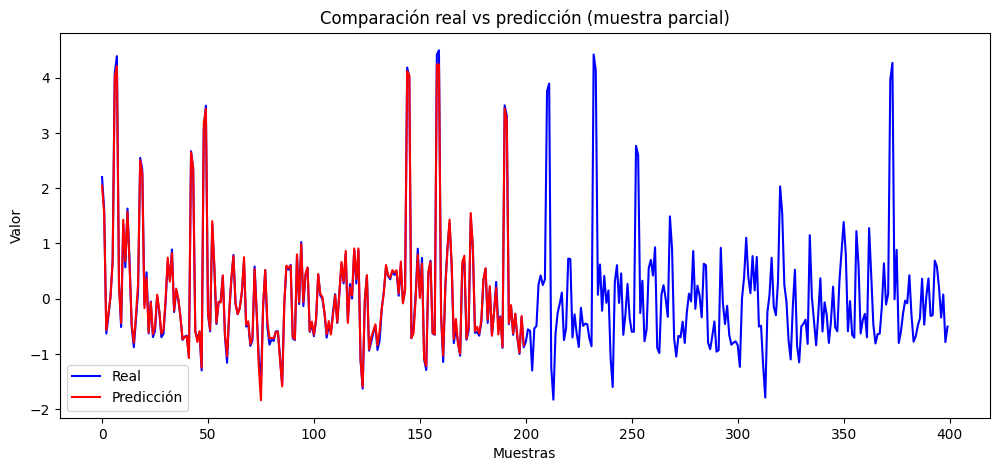

In [ ]:
# n_plot = 200  # número de muestras a mostrar
# plt.figure(figsize=(12,5))
# plt.plot(y_val[:n_plot].flatten(), label='Real', color='blue')
# plt.plot(y_pred[:n_plot].flatten(), label='Predicción', color='red')
# plt.title('Comparación real vs predicción (muestra parcial)')
# plt.xlabel('Muestras')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()


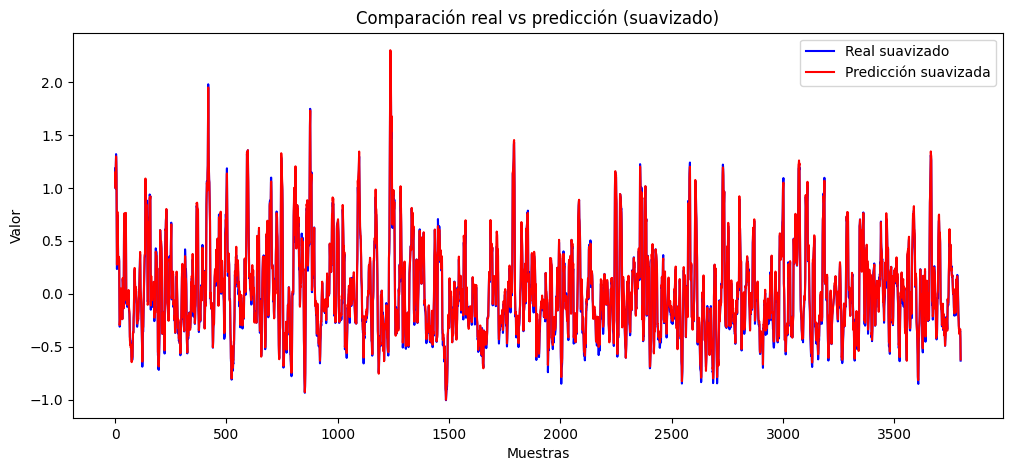

In [ ]:
# import numpy as np

# window = 10
# y_val_smooth = np.convolve(y_val.flatten(), np.ones(window)/window, mode='valid')
# y_pred_smooth = np.convolve(y_pred.flatten(), np.ones(window)/window, mode='valid')

# plt.figure(figsize=(12,5))
# plt.plot(y_val_smooth, label='Real suavizado', color='blue')
# plt.plot(y_pred_smooth, label='Predicción suavizada', color='red')
# plt.title('Comparación real vs predicción (suavizado)')
# plt.xlabel('Muestras')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()


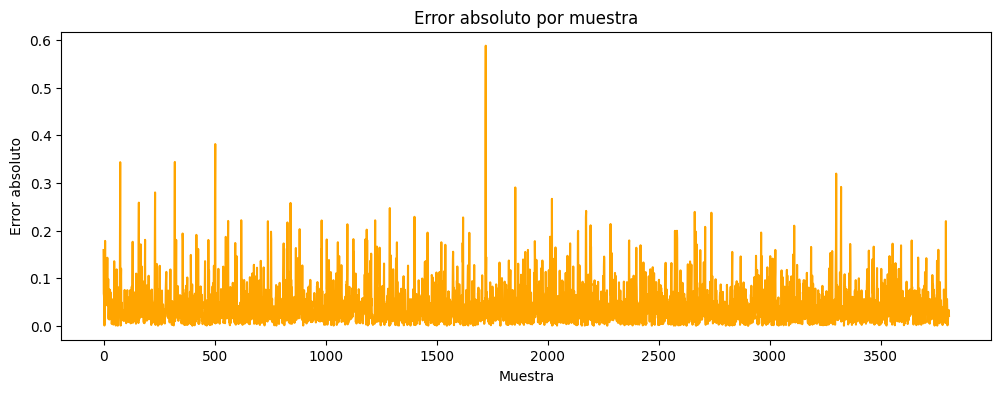

In [ ]:
# error = np.abs(y_val.flatten() - y_pred.flatten())

# plt.figure(figsize=(12,4))
# plt.plot(error, color='orange')
# plt.title('Error absoluto por muestra')
# plt.xlabel('Muestra')
# plt.ylabel('Error absoluto')
# plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


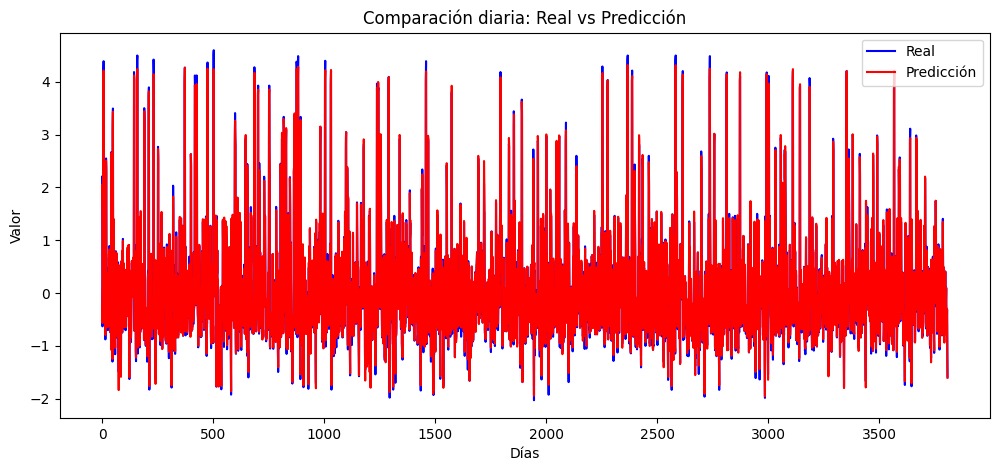

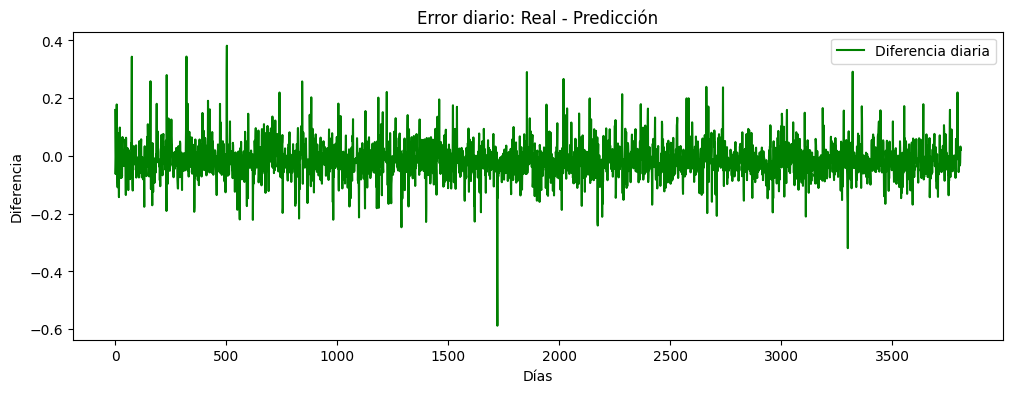

In [ ]:
# # Suponiendo que X_val y y_val existen
# y_pred = best_model.predict(X_val).flatten()
# y_true = y_val.flatten()

# # Diferencia diaria
# diff_daily = y_true - y_pred

# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,5))
# plt.plot(y_true, label='Real', color='blue')
# plt.plot(y_pred, label='Predicción', color='red')
# plt.title('Comparación diaria: Real vs Predicción')
# plt.xlabel('Días')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()

# plt.figure(figsize=(12,4))
# plt.plot(diff_daily, label='Diferencia diaria', color='green')
# plt.title('Error diario: Real - Predicción')
# plt.xlabel('Días')
# plt.ylabel('Diferencia')
# plt.legend()
# plt.show()


ValueError: x and y must have same first dimension, but have shapes (1904,) and (3808,)

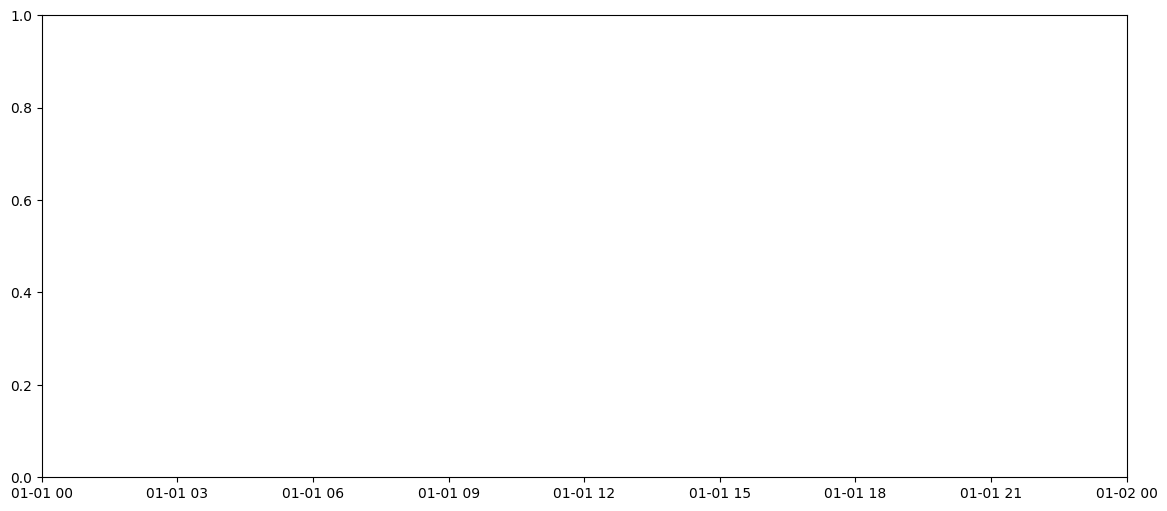

In [ ]:
# # y_val: cierres reales
# # y_pred: predicciones del modelo
# # dates_val: fechas correspondientes a y_val

# import matplotlib.pyplot as plt

# plt.figure(figsize=(14,6))
# plt.plot(dates_val, y_val.flatten(), label='Cierre real', color='blue')
# plt.plot(dates_val, y_pred.flatten(), label='Predicción modelo', color='red', alpha=0.7)
# plt.title('Evolución de cierres reales vs predicción')
# plt.xlabel('Fecha')
# plt.ylabel('Precio cierre')
# plt.legend()
# plt.grid(True)
# plt.show()


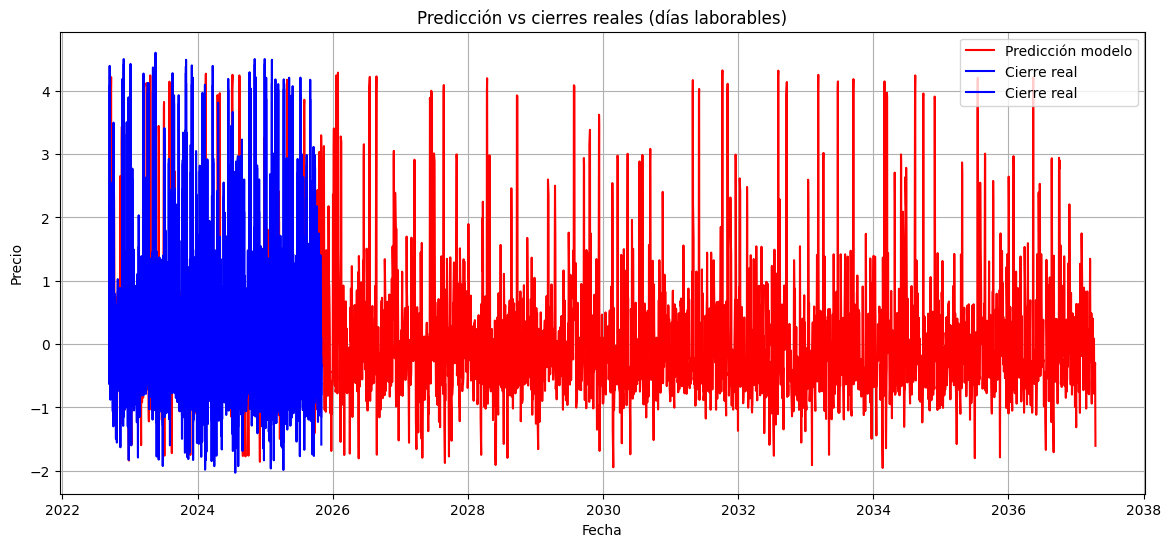

In [ ]:
# import pandas as pd

# dates_all = pd.date_range(start=dates_val_1d[0], periods=len(y_pred_1d), freq='B')  # 'B' = días laborables
# plt.figure(figsize=(14,6))
# plt.plot(dates_all, y_pred_1d, label='Predicción modelo', color='red')
# plt.plot(dates_val_1d, y_val[:len(dates_val_1d)], label='Cierre real', color='blue')
# plt.title('Predicción vs cierres reales (días laborables)')
# plt.xlabel('Fecha')
# plt.ylabel('Precio')
# plt.legend()
# plt.grid(True)
# plt.show()


# Final

## Final 1: no

In [ ]:
# # ==============================
# # ENTRENAMIENTO RED LSTM FIJA
# # ==============================

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, Callback
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import time
# import random

In [ ]:
# # ------------------------------
# # Callback para imprimir métricas y tiempo por epoch
# # ------------------------------
# class TimeHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.times = []
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_time_start = time.time()
#     def on_epoch_end(self, epoch, logs=None):
#         elapsed = time.time() - self.epoch_time_start
#         self.times.append(elapsed)
#         print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - "
#               f"loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - "
#               f"mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# # ------------------------------
# # Función para construir el modelo LSTM fijo
# # ------------------------------
# def build_fixed_lstm(input_shape, output_size):
#     model = Sequential()
#     # Capa 1
#     model.add(LSTM(256, input_shape=input_shape, return_sequences=True,
#                    kernel_regularizer=regularizers.l2(0.001)))
#     model.add(Dropout(0.3))
#     # Capa 2
#     model.add(LSTM(128, return_sequences=False,
#                    kernel_regularizer=regularizers.l2(0.001)))
#     model.add(Dropout(0.2))
#     # Capa de salida
#     model.add(Dense(output_size))
    
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # ------------------------------
# # Preparar datos
# # ------------------------------
# # X_1, y_1 deben estar definidos previamente
# X, y = X_1, y_1
# y = y.reshape(y.shape[0], -1)

# # División train/validation
# from sklearn.model_selection import train_test_split
# # Split X, y
# X_train, X_val, y_train, y_val, = train_test_split(X_1, y_1, test_size=0.2, random_state=SEED)

# # Split dates_all_1 de forma sincronizada
# dates_train, dates_val = train_test_split(dates_all_1, test_size=0.2, random_state=SEED)

# input_shape = (X_train.shape[1], X_train.shape[2])
# output_size = y_train.shape[1]

# # ------------------------------
# # Reshape de y para Keras
# # ------------------------------
# y_train = y_train.reshape(y_train.shape[0], -1)
# y_val   = y_val.reshape(y_val.shape[0], -1)

# # ------------------------------
# # Entrenamiento
# # ------------------------------
# model = build_fixed_lstm(input_shape, output_size)
# time_callback = TimeHistory()
# early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=200,
#     batch_size=32,
#     callbacks=[early_stop, time_callback],
#     verbose=0
# )

Epoch 1 - tiempo: 5.28s - loss: 0.235682 - val_loss: 0.126879 - mae: 0.240088 - val_mae: 0.223747
Epoch 2 - tiempo: 2.63s - loss: 0.107874 - val_loss: 0.096726 - mae: 0.223682 - val_mae: 0.221875
Epoch 3 - tiempo: 2.48s - loss: 0.092876 - val_loss: 0.089634 - mae: 0.226431 - val_mae: 0.232979
Epoch 4 - tiempo: 2.50s - loss: 0.081558 - val_loss: 0.074552 - mae: 0.222373 - val_mae: 0.214304
Epoch 5 - tiempo: 2.57s - loss: 0.077946 - val_loss: 0.071539 - mae: 0.222647 - val_mae: 0.213061
Epoch 6 - tiempo: 2.47s - loss: 0.077130 - val_loss: 0.082990 - mae: 0.222549 - val_mae: 0.236108
Epoch 7 - tiempo: 2.55s - loss: 0.075630 - val_loss: 0.073386 - mae: 0.222230 - val_mae: 0.218584
Epoch 8 - tiempo: 2.43s - loss: 0.076185 - val_loss: 0.070303 - mae: 0.223202 - val_mae: 0.213858
Epoch 9 - tiempo: 2.42s - loss: 0.074273 - val_loss: 0.071930 - mae: 0.221525 - val_mae: 0.217322
Epoch 10 - tiempo: 2.47s - loss: 0.074339 - val_loss: 0.069092 - mae: 0.221069 - val_mae: 0.214018
Epoch 11 - tiempo: 

In [ ]:
# # ------------------------------
# # Guardar modelo
# # ------------------------------
# model.save("../models/lstm_256_128_drop0.3_0.2_bs32.h5")
# print("Modelo guardado para deploy web.")

Modelo guardado para deploy web.


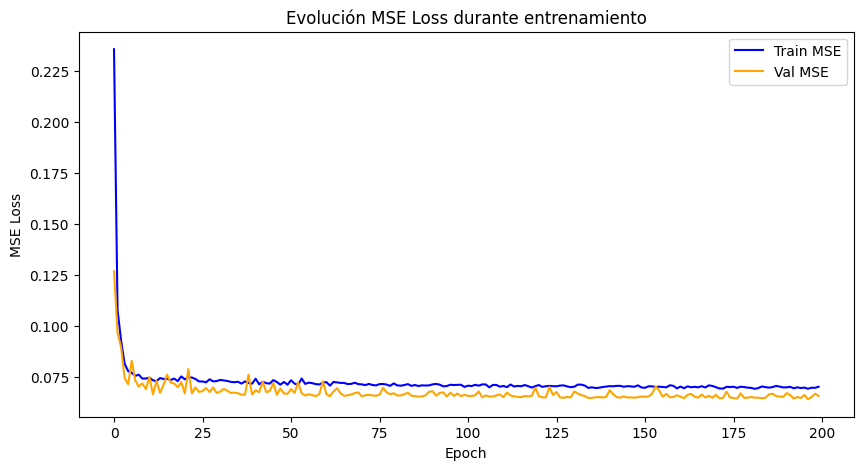

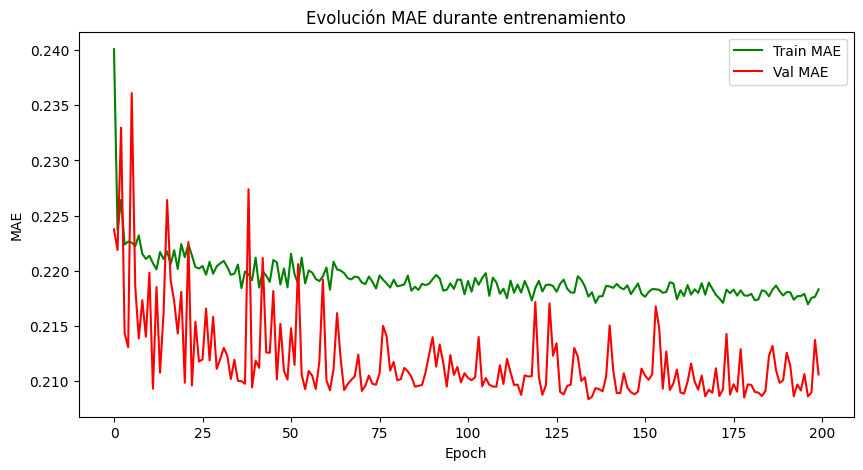

In [ ]:
# # ------------------------------
# # GRAFICAS DE ENTRENAMIENTO
# # ------------------------------

# # Loss (MSE) entrenamiento y validación
# plt.figure(figsize=(10,5))
# plt.plot(history.history['loss'], label='Train MSE', color='blue')
# plt.plot(history.history['val_loss'], label='Val MSE', color='orange')
# plt.title('Evolución MSE Loss durante entrenamiento')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.ylim(0,1) 
# plt.legend()
# plt.show()

# # MAE entrenamiento y validación
# plt.figure(figsize=(10,5))
# plt.plot(history.history['mae'], label='Train MAE', color='green')
# plt.plot(history.history['val_mae'], label='Val MAE', color='red')
# plt.title('Evolución MAE durante entrenamiento')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.ylim(0,1) 
# plt.legend()
# plt.show()

In [ ]:
# # ------------------------------
# # Predicción
# # ------------------------------
# y_pred = model.predict(X_val)

# # -------------------------------
# # Crear DataFrames para Santander y BBVA
# # -------------------------------
# df_val_bbva = pd.DataFrame({
#     'date': dates_val,
#     'y_real': y_val[:,0],  # BBVA
#     'y_pred': y_pred[:,0]
# })

# df_val_san = pd.DataFrame({
#     'date': dates_val,
#     'y_real': y_val[:,1],  # SAN
#     'y_pred': y_pred[:,1]
# })

# df_val_bbva['month'] = df_val_bbva['date'].dt.to_period('M')
# df_val_san['month'] = df_val_san['date'].dt.to_period('M')

# last_month_bbva = df_val_bbva['date'].dt.to_period('M').max()
# df_last_bbva = df_val_bbva[df_val_bbva['date'].dt.to_period('M') == last_month_bbva]

# last_month_san = df_val_san['date'].dt.to_period('M').max()
# df_last_san = df_val_san[df_val_san['date'].dt.to_period('M') == last_month_san]


# # ------------------------------
# # Gráfico general: Predicción vs Real
# # ------------------------------
# plt.figure(figsize=(12,5))
# plt.plot(y_val.flatten(), label='Real', color='blue')
# plt.plot(y_pred.flatten(), label='Predicción', color='red')
# plt.title('Comparación real vs predicción (validación)')
# plt.xlabel('Muestras')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()



60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# # ------------------------------
# # Agregar datos por mes para serie mensual
# # ------------------------------
# # Serie mensual agregada para BBVA
# df_monthly_bbva = df_val_bbva.groupby('month').mean()
# plt.figure(figsize=(12,5))
# plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_real'], label='BBVA Real', color='blue')
# plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_pred'], label='BBVA Predicción', color='red')
# plt.title('Serie mensual agregada BBVA: Predicción vs Real')
# plt.xlabel('Mes')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()

# # Serie mensual agregada para SAN
# df_monthly_san = df_val_san.groupby('month').mean()
# plt.figure(figsize=(12,5))
# plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_real'], label='SAN Real', color='blue')
# plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_pred'], label='SAN Predicción', color='red')
# plt.title('Serie mensual agregada SAN: Predicción vs Real')
# plt.xlabel('Mes')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()


NameError: name 'df_val_bbva' is not defined

In [ ]:
# # ------------------------------
# # Último mes + próximos 5 días (diario)
# # ------------------------------
# last_month = df_val['date'].dt.to_period('M').max()
# df_last = df_val[df_val['date'].dt.to_period('M') == last_month]

# plt.figure(figsize=(12,5))
# plt.plot(df_last['date'], df_last['y_real'], label='Real', color='blue')
# plt.plot(df_last['date'], df_last['y_pred'], label='Predicción', color='red')
# plt.title('Último mes: Predicción vs Real (diario)')
# plt.xlabel('Fecha')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()

## Final 1

In [ ]:
# # ------------------------------
# # Callback para métricas y tiempo
# # ------------------------------
# class TimeHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.times = []
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_time_start = time.time()
#     def on_epoch_end(self, epoch, logs=None):
#         elapsed = time.time() - self.epoch_time_start
#         self.times.append(elapsed)
#         print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - "
#               f"loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - "
#               f"mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# # ------------------------------
# # Función LSTM
# # ------------------------------
# def build_fixed_lstm(input_shape, output_size=2):
#     model = Sequential()
#     model.add(LSTM(256, input_shape=input_shape, return_sequences=True,
#                    kernel_regularizer=regularizers.l2(0.001)))
#     model.add(Dropout(0.3))
#     model.add(LSTM(128, return_sequences=False,
#                    kernel_regularizer=regularizers.l2(0.001)))
#     model.add(Dropout(0.2))
#     model.add(Dense(output_size))  # 2 salidas: BBVA y SAN
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# # ------------------------------
# # Preparar datos
# # ------------------------------
# X = X_1
# y = y_1.reshape(y_1.shape[0], y_1.shape[2])  # (samples, 2)

# # División sincronizada
# X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
#     X, y, dates_all_1, test_size=0.2, random_state=SEED
# )

# input_shape = (X_train.shape[1], X_train.shape[2])
# output_size = y_train.shape[1]  # 2

# # ------------------------------
# # Entrenamiento
# # ------------------------------
# model = build_fixed_lstm(input_shape, output_size)
# time_callback = TimeHistory()
# early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=200,
#     batch_size=32,
#     callbacks=[early_stop, time_callback],
#     verbose=0
# )


Epoch 1 - tiempo: 4.91s - loss: 0.194958 - val_loss: 0.068764 - mae: 0.129161 - val_mae: 0.090769
Epoch 2 - tiempo: 2.90s - loss: 0.049035 - val_loss: 0.028644 - mae: 0.084944 - val_mae: 0.062293
Epoch 3 - tiempo: 2.68s - loss: 0.029859 - val_loss: 0.024539 - mae: 0.082196 - val_mae: 0.084548
Epoch 4 - tiempo: 2.78s - loss: 0.024932 - val_loss: 0.016885 - mae: 0.084643 - val_mae: 0.071707
Epoch 5 - tiempo: 2.70s - loss: 0.021344 - val_loss: 0.014763 - mae: 0.082211 - val_mae: 0.066562
Epoch 6 - tiempo: 2.55s - loss: 0.018510 - val_loss: 0.013275 - mae: 0.077601 - val_mae: 0.067201
Epoch 7 - tiempo: 2.46s - loss: 0.022461 - val_loss: 0.016407 - mae: 0.086525 - val_mae: 0.069049
Epoch 8 - tiempo: 2.42s - loss: 0.017286 - val_loss: 0.011656 - mae: 0.075535 - val_mae: 0.055465
Epoch 9 - tiempo: 2.46s - loss: 0.016767 - val_loss: 0.011895 - mae: 0.076195 - val_mae: 0.060174
Epoch 10 - tiempo: 2.47s - loss: 0.018147 - val_loss: 0.012305 - mae: 0.078783 - val_mae: 0.064388
Epoch 11 - tiempo: 

In [ ]:
# # Guardar modelo en formato Keras moderno
# model.save("../models/lstm_256_128_drop0.3_0.2_bs32.keras")
# print("Modelo guardado para deploy web.")

Modelo guardado para deploy web.


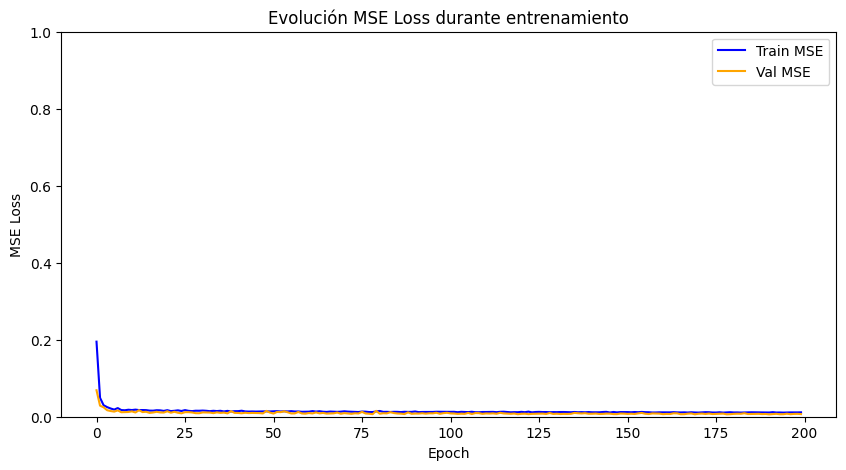

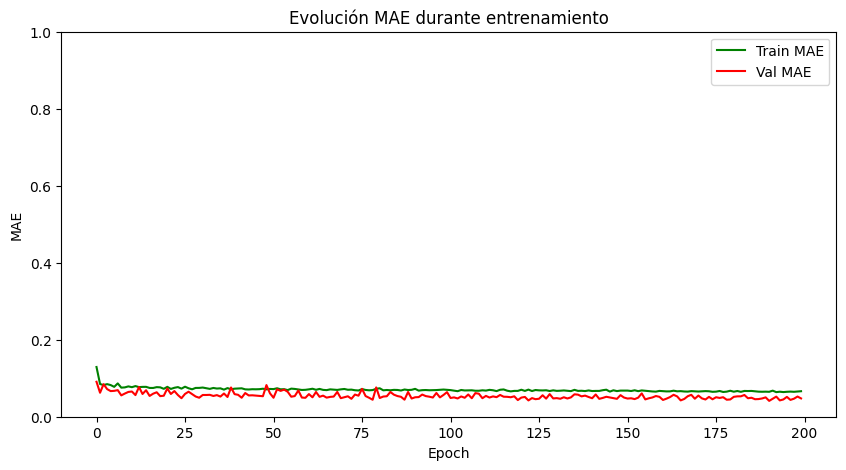

In [ ]:
# # ------------------------------
# # GRAFICAS DE ENTRENAMIENTO
# # ------------------------------

# # Loss (MSE) entrenamiento y validación
# plt.figure(figsize=(10,5))
# plt.plot(history.history['loss'], label='Train MSE', color='blue')
# plt.plot(history.history['val_loss'], label='Val MSE', color='orange')
# plt.title('Evolución MSE Loss durante entrenamiento')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.ylim(0,1) 
# plt.legend()
# plt.show()

# # MAE entrenamiento y validación
# plt.figure(figsize=(10,5))
# plt.plot(history.history['mae'], label='Train MAE', color='green')
# plt.plot(history.history['val_mae'], label='Val MAE', color='red')
# plt.title('Evolución MAE durante entrenamiento')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.ylim(0,1) 
# plt.legend()
# plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


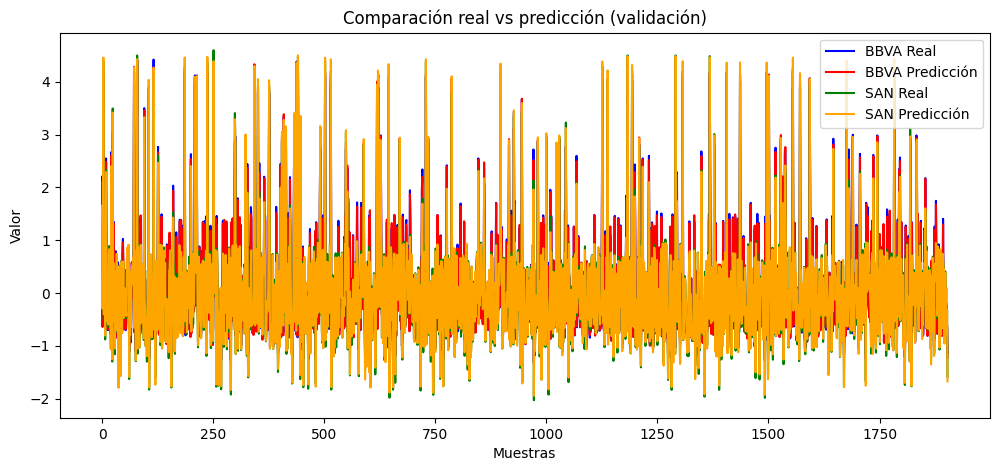

In [ ]:
# # ------------------------------
# # Predicción
# # ------------------------------
# y_pred = model.predict(X_val)  # shape: (samples, 2)

# # -------------------------------
# # Crear DataFrames para Santander y BBVA
# # -------------------------------
# df_val_bbva = pd.DataFrame({
#     'date': dates_val,
#     'y_real': y_val[:,0],  # BBVA
#     'y_pred': y_pred[:,0]
# })

# df_val_san = pd.DataFrame({
#     'date': dates_val,
#     'y_real': y_val[:,1],  # SAN
#     'y_pred': y_pred[:,1]
# })

# # Agregar columna 'month' para series mensuales
# df_val_bbva['month'] = df_val_bbva['date'].dt.to_period('M')
# df_val_san['month'] = df_val_san['date'].dt.to_period('M')

# # ------------------------------
# # Gráfico general: Predicción vs Real (todo el periodo)
# # ------------------------------
# plt.figure(figsize=(12,5))
# plt.plot(df_val_bbva['y_real'], label='BBVA Real', color='blue')
# plt.plot(df_val_bbva['y_pred'], label='BBVA Predicción', color='red')
# plt.plot(df_val_san['y_real'], label='SAN Real', color='green')
# plt.plot(df_val_san['y_pred'], label='SAN Predicción', color='orange')
# plt.title('Comparación real vs predicción (validación)')
# plt.xlabel('Muestras')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()

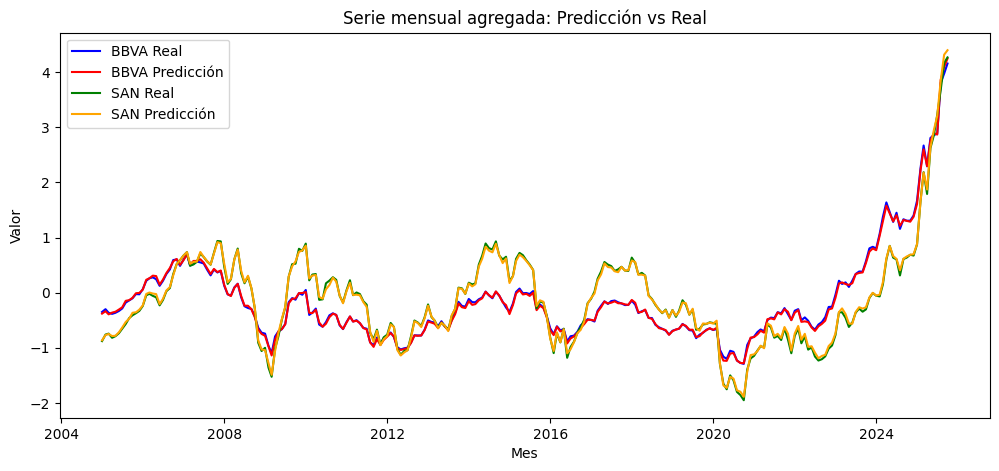

In [ ]:
# # ------------------------------
# # Serie mensual agregada
# # ------------------------------
# df_monthly_bbva = df_val_bbva.groupby('month').mean()
# df_monthly_san  = df_val_san.groupby('month').mean()

# plt.figure(figsize=(12,5))
# plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_real'], label='BBVA Real', color='blue')
# plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_pred'], label='BBVA Predicción', color='red')
# plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_real'], label='SAN Real', color='green')
# plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_pred'], label='SAN Predicción', color='orange')
# plt.title('Serie mensual agregada: Predicción vs Real')
# plt.xlabel('Mes')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()


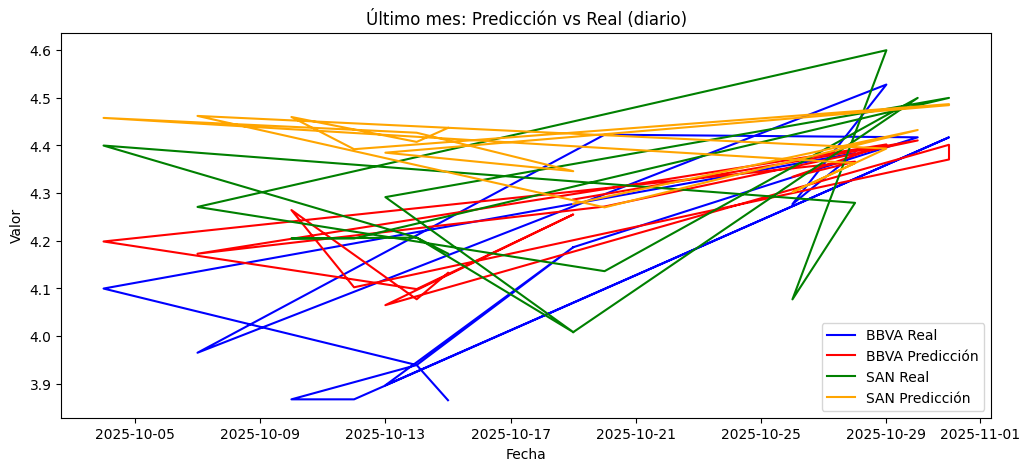

In [ ]:
# # ------------------------------
# # Último mes (diario)
# # ------------------------------
# last_month_bbva = df_val_bbva['month'].max()
# df_last_bbva = df_val_bbva[df_val_bbva['month'] == last_month_bbva]

# last_month_san = df_val_san['month'].max()
# df_last_san = df_val_san[df_val_san['month'] == last_month_san]

# plt.figure(figsize=(12,5))
# plt.plot(df_last_bbva['date'], df_last_bbva['y_real'], label='BBVA Real', color='blue')
# plt.plot(df_last_bbva['date'], df_last_bbva['y_pred'], label='BBVA Predicción', color='red')
# plt.plot(df_last_san['date'], df_last_san['y_real'], label='SAN Real', color='green')
# plt.plot(df_last_san['date'], df_last_san['y_pred'], label='SAN Predicción', color='orange')
# plt.title('Último mes: Predicción vs Real (diario)')
# plt.xlabel('Fecha')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()

## fINAL 2

In [ ]:
# ------------------------------
# Callback para métricas y tiempo
# ------------------------------
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_time_start
        self.times.append(elapsed)
        print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - "
              f"loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - "
              f"mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# ------------------------------
# Función LSTM
# ------------------------------
def build_fixed_lstm(input_shape, output_size=2):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, return_sequences=True,
                   kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=False,
                   kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(output_size))  # 2 salidas: BBVA y SAN
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ------------------------------
# Preparar datos
# ------------------------------
X = X_1
y = y_1.reshape(y_1.shape[0], y_1.shape[2])  # (samples, 2)

# División sincronizada
X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
    X, y, dates_all_1, test_size=0.2, random_state=SEED
)

input_shape = (X_train.shape[1], X_train.shape[2])
output_size = y_train.shape[1]  # 2

# ------------------------------
# Entrenamiento
# ------------------------------
model = build_fixed_lstm(input_shape, output_size)
time_callback = TimeHistory()
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, time_callback],
    verbose=0
)


c:\Proyectos - UAX\CRR-Prediccion_acciones\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - tiempo: 5.32s - loss: 0.197532 - val_loss: 0.066579 - mae: 0.132969 - val_mae: 0.073646
Epoch 2 - tiempo: 2.93s - loss: 0.053262 - val_loss: 0.031753 - mae: 0.091244 - val_mae: 0.067774
Epoch 3 - tiempo: 3.28s - loss: 0.031323 - val_loss: 0.028612 - mae: 0.083599 - val_mae: 0.088112
Epoch 4 - tiempo: 3.36s - loss: 0.025803 - val_loss: 0.022568 - mae: 0.086490 - val_mae: 0.084915
Epoch 5 - tiempo: 3.07s - loss: 0.020752 - val_loss: 0.013714 - mae: 0.080539 - val_mae: 0.059994
Epoch 6 - tiempo: 3.00s - loss: 0.019109 - val_loss: 0.015401 - mae: 0.078858 - val_mae: 0.075272
Epoch 7 - tiempo: 3.23s - loss: 0.017548 - val_loss: 0.024367 - mae: 0.077609 - val_mae: 0.099943
Epoch 8 - tiempo: 3.79s - loss: 0.018708 - val_loss: 0.010665 - mae: 0.078493 - val_mae: 0.053026
Epoch 9 - tiempo: 3.74s - loss: 0.015876 - val_loss: 0.011987 - mae: 0.074398 - val_mae: 0.061867
Epoch 10 - tiempo: 3.62s - loss: 0.019245 - val_loss: 0.017923 - mae: 0.081422 - val_mae: 0.084328
Epoch 11 - tiempo: 

In [111]:
# ------------------------------
# 1️⃣ Predicción con el modelo
# ------------------------------
y_pred = model.predict(X_val)

# ------------------------------
# 2️⃣ Invertir escalado
# ------------------------------
def inverse_y(scaled_y, scaler, n_features_total, target_indices=[0,1]):
    n_samples = scaled_y.shape[0]
    temp = np.zeros((n_samples, n_features_total))
    for i, idx in enumerate(target_indices):
        temp[:, idx] = scaled_y[:, i]
    inv = scaler.inverse_transform(temp)
    return inv[:, target_indices]

n_features_total = data_scaled.shape[1]
target_cols = ['BBVA.MC_Close','SAN.MC_Close']
target_indices = [data_rnn.columns.get_loc(c) for c in target_cols]

y_val_inv  = inverse_y(y_val, scaler, n_features_total, target_indices)
y_pred_inv = inverse_y(y_pred, scaler, n_features_total, target_indices)

# ------------------------------
# 3️⃣ Último mes del dataset real
# ------------------------------
last_month_real = data_rnn.index.to_period('M').max()

# Fechas reales de mercado del último mes
dates_real_last_month = data_rnn.loc[data_rnn.index.to_period('M') == last_month_real].index

# ------------------------------
# 4️⃣ Crear df final con valores reales y predicciones alineadas
# ------------------------------
df_last_full_real = pd.DataFrame({
    'date': dates_real_last_month,
    'BBVA_real': data_rnn.loc[dates_real_last_month, 'BBVA.MC_Close'].values,
    'SAN_real':  data_rnn.loc[dates_real_last_month, 'SAN.MC_Close'].values,
})

# Inicializar columnas de predicción con NaN
df_last_full_real['BBVA_pred'] = np.nan
df_last_full_real['SAN_pred']  = np.nan

# Mapear predicciones solo donde hay datos de validación
for i, d in enumerate(dates_val):
    if d in dates_real_last_month:
        idx = df_last_full_real.index[df_last_full_real['date'] == d][0]
        df_last_full_real.at[idx, 'BBVA_pred'] = y_pred_inv[i, 0]
        df_last_full_real.at[idx, 'SAN_pred']  = y_pred_inv[i, 1]

# ------------------------------
# 5️⃣ Mostrar DataFrame final
# ------------------------------
display(df_last_full_real)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ValueError: All arrays must be of the same length

In [107]:
# ------------------------------
# 1️⃣ Último mes del dataset
# ------------------------------
last_month = df_val_bbva['month'].max()

# Filtrar último mes para cada activo
df_last_bbva = df_val_bbva[df_val_bbva['month'] == last_month].copy()
df_last_san  = df_val_san[df_val_san['month'] == last_month].copy()

# ------------------------------
# 2️⃣ Eliminar duplicados por fecha
# ------------------------------
df_last_bbva = df_last_bbva.drop_duplicates(subset='date').reset_index(drop=True)
df_last_san  = df_last_san.drop_duplicates(subset='date').reset_index(drop=True)

# ------------------------------
# 3️⃣ Crear índice de fechas de mercado usando solo fechas reales
# ------------------------------
full_dates = sorted(set(df_last_bbva['date']).union(set(df_last_san['date'])))

# ------------------------------
# 4️⃣ Mapear valores a fechas completas sin interpolar (solo los reales)
# ------------------------------
df_last_full = pd.DataFrame({
    'date': full_dates,
    'BBVA_real': [df_last_bbva.loc[df_last_bbva['date'] == d, 'y_real'].values[0] for d in full_dates],
    'BBVA_pred': [df_last_bbva.loc[df_last_bbva['date'] == d, 'y_pred'].values[0] for d in full_dates],
    'SAN_real':  [df_last_san.loc[df_last_san['date'] == d, 'y_real'].values[0] for d in full_dates],
    'SAN_pred':  [df_last_san.loc[df_last_san['date'] == d, 'y_pred'].values[0] for d in full_dates]
})

# ------------------------------
# 5️⃣ Mostrar DataFrame final
# ------------------------------
display(df_last_full)


,date,BBVA_real,BBVA_pred,SAN_real,SAN_pred
0,2025-10-04,16.420000,16.268747,8.634984,8.486940
1,2025-10-07,16.055000,16.239431,8.486905,8.503326
2,2025-10-10,15.790000,16.031980,8.410892,8.600498
3,2025-10-12,15.790000,16.125697,8.410892,8.462986
4,2025-10-13,15.870000,16.113924,8.510598,8.471188
5,2025-10-14,15.985000,16.063083,8.412866,8.456158
6,2025-10-15,15.785000,16.092059,8.374365,8.457101
7,2025-10-19,16.655001,16.590349,8.184824,8.325752
8,2025-10-20,17.295000,16.521470,8.331915,8.298861
9,2025-10-26,16.900000,16.660380,8.263800,8.331857


In [63]:
# Guardar modelo en formato Keras moderno
model.save("../../results/models/lstm_256_128_drop0.3_0.2_bs32_2.keras")
print("Modelo guardado para deploy web.")

Modelo guardado para deploy web.


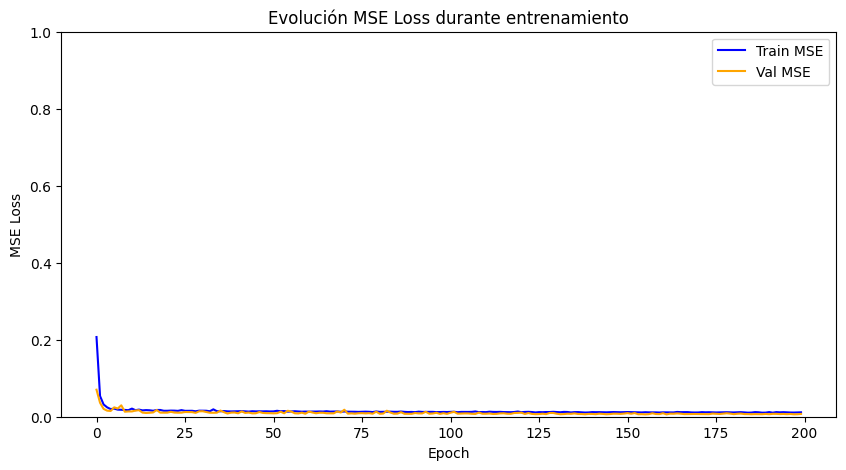

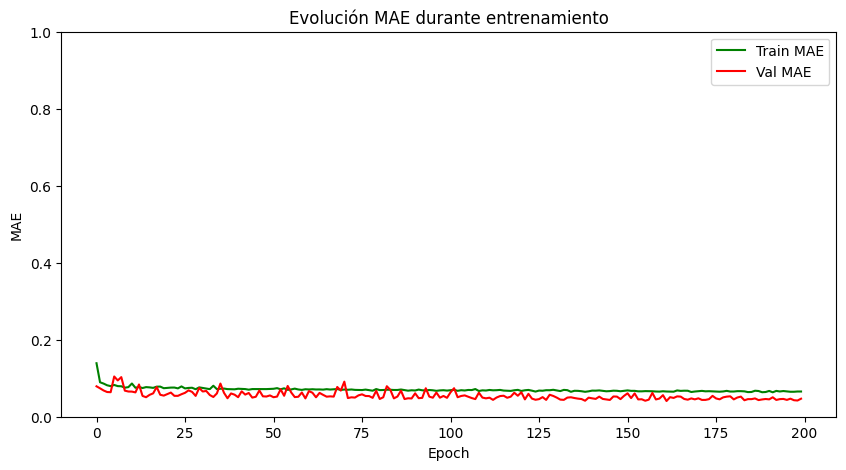

In [64]:
# ------------------------------
# GRAFICAS DE ENTRENAMIENTO
# ------------------------------

# Loss (MSE) entrenamiento y validación
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train MSE', color='blue')
plt.plot(history.history['val_loss'], label='Val MSE', color='orange')
plt.title('Evolución MSE Loss durante entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.ylim(0,1) 
plt.legend()
plt.show()

# MAE entrenamiento y validación
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución MAE durante entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim(0,1) 
plt.legend()
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


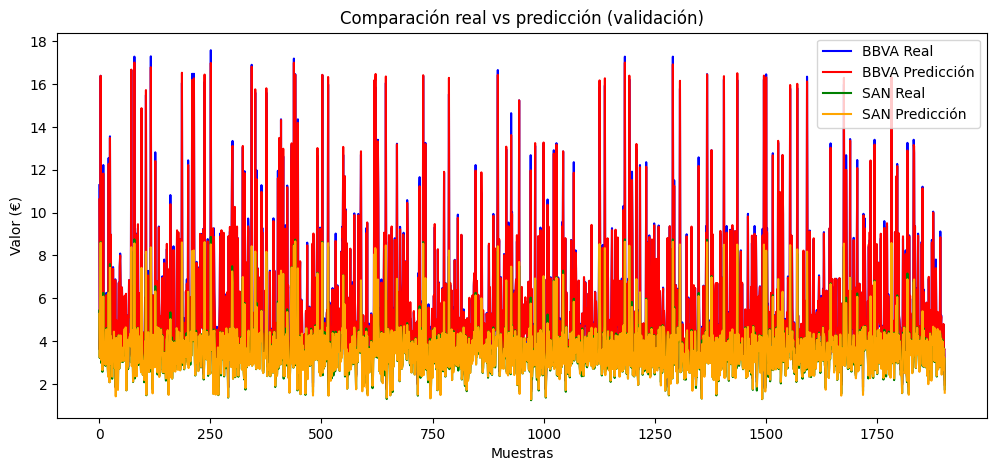

In [82]:
# ===============================
# Predicción
# ===============================
y_pred = model.predict(X_val)  # shape: (samples, 2)

# ------------------------------
# INVERTIR ESCALADO PARA RECUPERAR PRECIOS REALES (€)
# ------------------------------

# Reentrenar un scaler solo con las columnas objetivo (BBVA y SAN)
from sklearn.preprocessing import StandardScaler
scaler_target = StandardScaler()
scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

# Invertir escalado de las predicciones y los valores reales
y_val_inv  = scaler_target.inverse_transform(y_val)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# ------------------------------- 
# Crear DataFrames para Santander y BBVA usando valores invertidos
# -------------------------------
df_val_bbva = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,0],  # BBVA
    'y_pred': y_pred_inv[:,0]
})

df_val_san = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,1],  # SAN
    'y_pred': y_pred_inv[:,1]
})

# Agregar columna 'month' para series mensuales
df_val_bbva['month'] = df_val_bbva['date'].dt.to_period('M')
df_val_san['month'] = df_val_san['date'].dt.to_period('M')

# ------------------------------
# Gráfico general: Predicción vs Real (todo el periodo)
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(df_val_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(df_val_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.plot(df_val_san['y_real'], label='SAN Real', color='green')
plt.plot(df_val_san['y_pred'], label='SAN Predicción', color='orange')
plt.title('Comparación real vs predicción (validación)')
plt.xlabel('Muestras')
plt.ylabel('Valor (€)')
plt.legend()
plt.show()


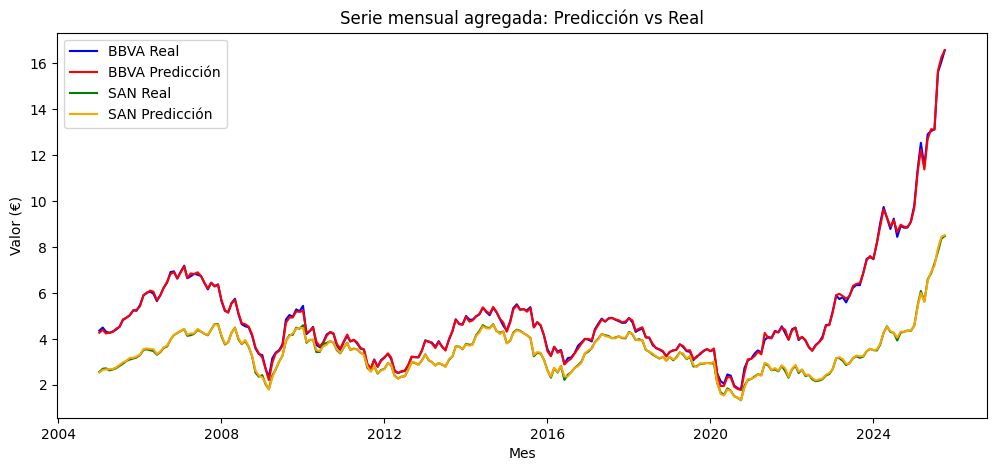

In [83]:
# ------------------------------
# Serie mensual agregada
# ------------------------------
df_monthly_bbva = df_val_bbva.groupby('month').mean()
df_monthly_san  = df_val_san.groupby('month').mean()

plt.figure(figsize=(12,5))
plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_real'], label='SAN Real', color='green')
plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_pred'], label='SAN Predicción', color='orange')
plt.title('Serie mensual agregada: Predicción vs Real')
plt.xlabel('Mes')
plt.ylabel('Valor (€)')
plt.legend()
plt.show()


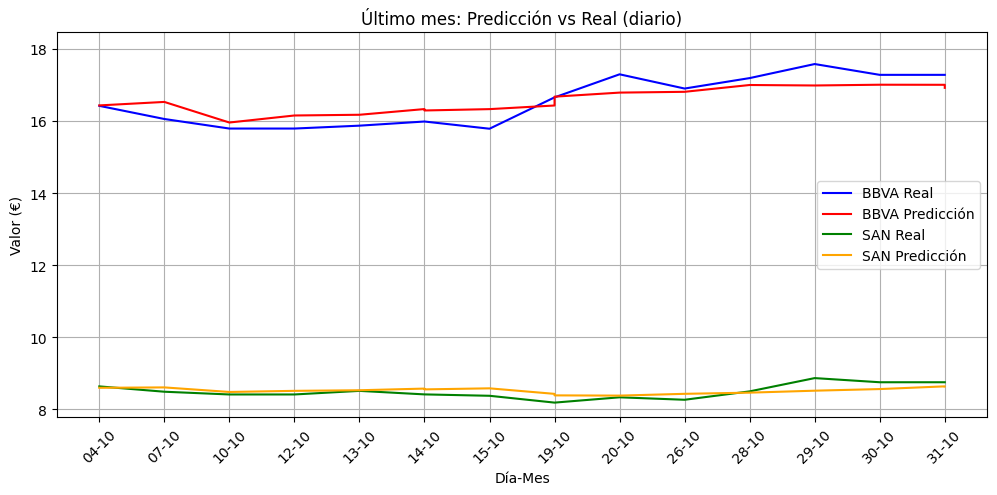

In [85]:
# ------------------------------
# Último mes (diario) corregido con todos los valores reales (€)
# ------------------------------

# Filtrar último mes y ordenar
last_month = df_val_bbva_inv['month'].max()
df_last_bbva = df_val_bbva_inv[df_val_bbva_inv['month'] == last_month].sort_values('date')
df_last_san  = df_val_san_inv[df_val_san_inv['month'] == last_month].sort_values('date')

# Usar un único eje X (los días del mes de BBVA o unión de fechas)
dates_plot = df_last_bbva['date'].dt.strftime('%d-%m')

plt.figure(figsize=(12,5))

plt.plot(dates_plot, df_last_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(dates_plot, df_last_bbva['y_pred'], label='BBVA Predicción', color='red')

# Para SAN, alineamos por fecha usando merge o reindex
df_last_san_aligned = df_last_san.set_index('date').reindex(df_last_bbva['date']).reset_index()
plt.plot(dates_plot, df_last_san_aligned['y_real'], label='SAN Real', color='green')
plt.plot(dates_plot, df_last_san_aligned['y_pred'], label='SAN Predicción', color='orange')

plt.title('Último mes: Predicción vs Real (diario)')
plt.xlabel('Día-Mes')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.ylim(
    min(df_last_bbva[['y_real','y_pred']].min().min(),
        df_last_san[['y_real','y_pred']].min().min())*0.95,
    max(df_last_bbva[['y_real','y_pred']].max().max(),
        df_last_san[['y_real','y_pred']].max().max())*1.05
)
plt.legend()
plt.grid(True)
plt.show()


## final 2.1 - graficos (lo mismo que rriba pero junto)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


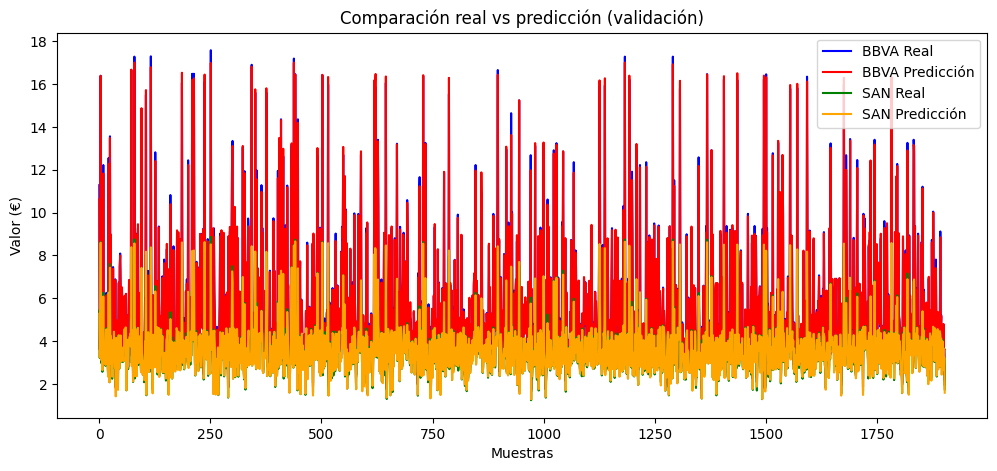

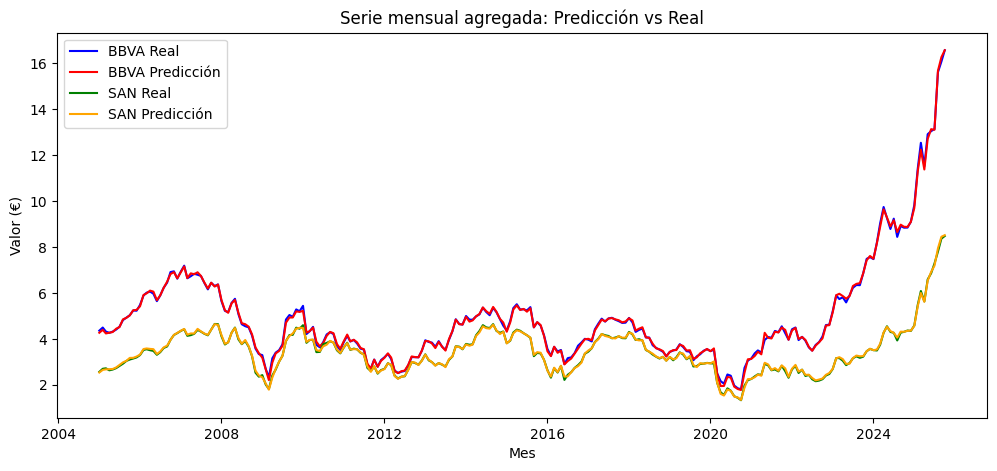

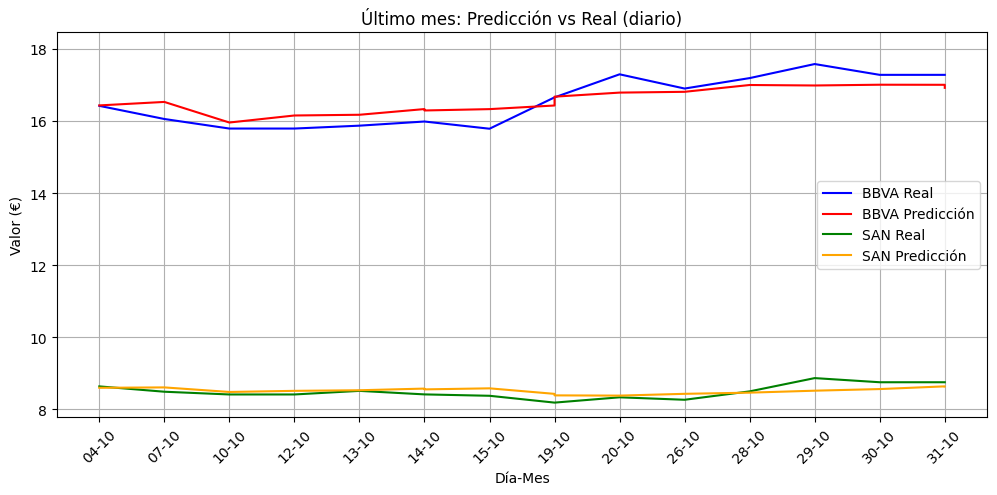

In [89]:
# ===============================
# Predicción
# ===============================
y_pred = model.predict(X_val)  # shape: (samples, 2)

# ------------------------------
# INVERTIR ESCALADO PARA RECUPERAR PRECIOS REALES (€)
# ------------------------------

# Usar el mismo scaler que aplicaste a todo data_rnn
# Escalado de datos: data_scaled = scaler.fit_transform(data_rnn)
# Para invertir, rellenamos columnas no objetivo con ceros y tomamos solo las dos últimas columnas

import numpy as np

def inverse_y(scaled_y, scaler, n_features_total, target_indices=[0,1]):
    """
    scaled_y: array (samples, n_targets)
    scaler: StandardScaler que se usó para data_rnn completa
    n_features_total: total de columnas de data_rnn
    target_indices: indices de las columnas objetivo dentro de data_rnn
    """
    n_samples = scaled_y.shape[0]
    temp = np.zeros((n_samples, n_features_total))
    # Poner las predicciones en las columnas correctas
    for i, idx in enumerate(target_indices):
        temp[:, idx] = scaled_y[:, i]
    # Invertir escalado
    inv = scaler.inverse_transform(temp)
    # Devolver solo las columnas objetivo
    return inv[:, target_indices]

# Aplicar
n_features_total = data_scaled.shape[1]  # número total de columnas en data_rnn
y_val_inv  = inverse_y(y_val, scaler, n_features_total, target_indices=[data_rnn.columns.get_loc('BBVA.MC_Close'),
                                                                       data_rnn.columns.get_loc('SAN.MC_Close')])
y_pred_inv = inverse_y(y_pred, scaler, n_features_total, target_indices=[data_rnn.columns.get_loc('BBVA.MC_Close'),
                                                                         data_rnn.columns.get_loc('SAN.MC_Close')])

# ------------------------------- 
# Crear DataFrames para Santander y BBVA usando valores invertidos
# -------------------------------
df_val_bbva = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,0],  # BBVA
    'y_pred': y_pred_inv[:,0]
})

df_val_san = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,1],  # SAN
    'y_pred': y_pred_inv[:,1]
})

# Agregar columna 'month' para series mensuales
df_val_bbva['month'] = df_val_bbva['date'].dt.to_period('M')
df_val_san['month'] = df_val_san['date'].dt.to_period('M')

# ------------------------------
# Gráfico general: Predicción vs Real (todo el periodo)
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(df_val_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(df_val_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.plot(df_val_san['y_real'], label='SAN Real', color='green')
plt.plot(df_val_san['y_pred'], label='SAN Predicción', color='orange')
plt.title('Comparación real vs predicción (validación)')
plt.xlabel('Muestras')
plt.ylabel('Valor (€)')
plt.legend()
plt.show()

# ------------------------------
# Serie mensual agregada
# ------------------------------
df_monthly_bbva = df_val_bbva.groupby('month').mean()
df_monthly_san  = df_val_san.groupby('month').mean()

plt.figure(figsize=(12,5))
plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(df_monthly_bbva.index.to_timestamp(), df_monthly_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_real'], label='SAN Real', color='green')
plt.plot(df_monthly_san.index.to_timestamp(), df_monthly_san['y_pred'], label='SAN Predicción', color='orange')
plt.title('Serie mensual agregada: Predicción vs Real')
plt.xlabel('Mes')
plt.ylabel('Valor (€)')
plt.legend()
plt.show()

# ------------------------------
# Último mes (diario) corregido
# ------------------------------
# Filtrar último mes y ordenar por fecha
last_month = df_val_bbva['month'].max()
df_last_bbva = df_val_bbva[df_val_bbva['month'] == last_month].sort_values('date')
df_last_san  = df_val_san[df_val_san['month'] == last_month].sort_values('date')

# Usar un único eje X
dates_plot = df_last_bbva['date'].dt.strftime('%d-%m')

# Alinear SAN con las fechas de BBVA
df_last_san_aligned = df_last_san.set_index('date').reindex(df_last_bbva['date']).reset_index()

plt.figure(figsize=(12,5))
plt.plot(dates_plot, df_last_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(dates_plot, df_last_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.plot(dates_plot, df_last_san_aligned['y_real'], label='SAN Real', color='green')
plt.plot(dates_plot, df_last_san_aligned['y_pred'], label='SAN Predicción', color='orange')

plt.title('Último mes: Predicción vs Real (diario)')
plt.xlabel('Día-Mes')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.ylim(
    min(df_last_bbva[['y_real','y_pred']].min().min(),
        df_last_san[['y_real','y_pred']].min().min())*0.95,
    max(df_last_bbva[['y_real','y_pred']].max().max(),
        df_last_san[['y_real','y_pred']].max().max())*1.05
)
plt.legend()
plt.grid(True)
plt.show()


## 2.2 (todos juntos y separado por bbva y san)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


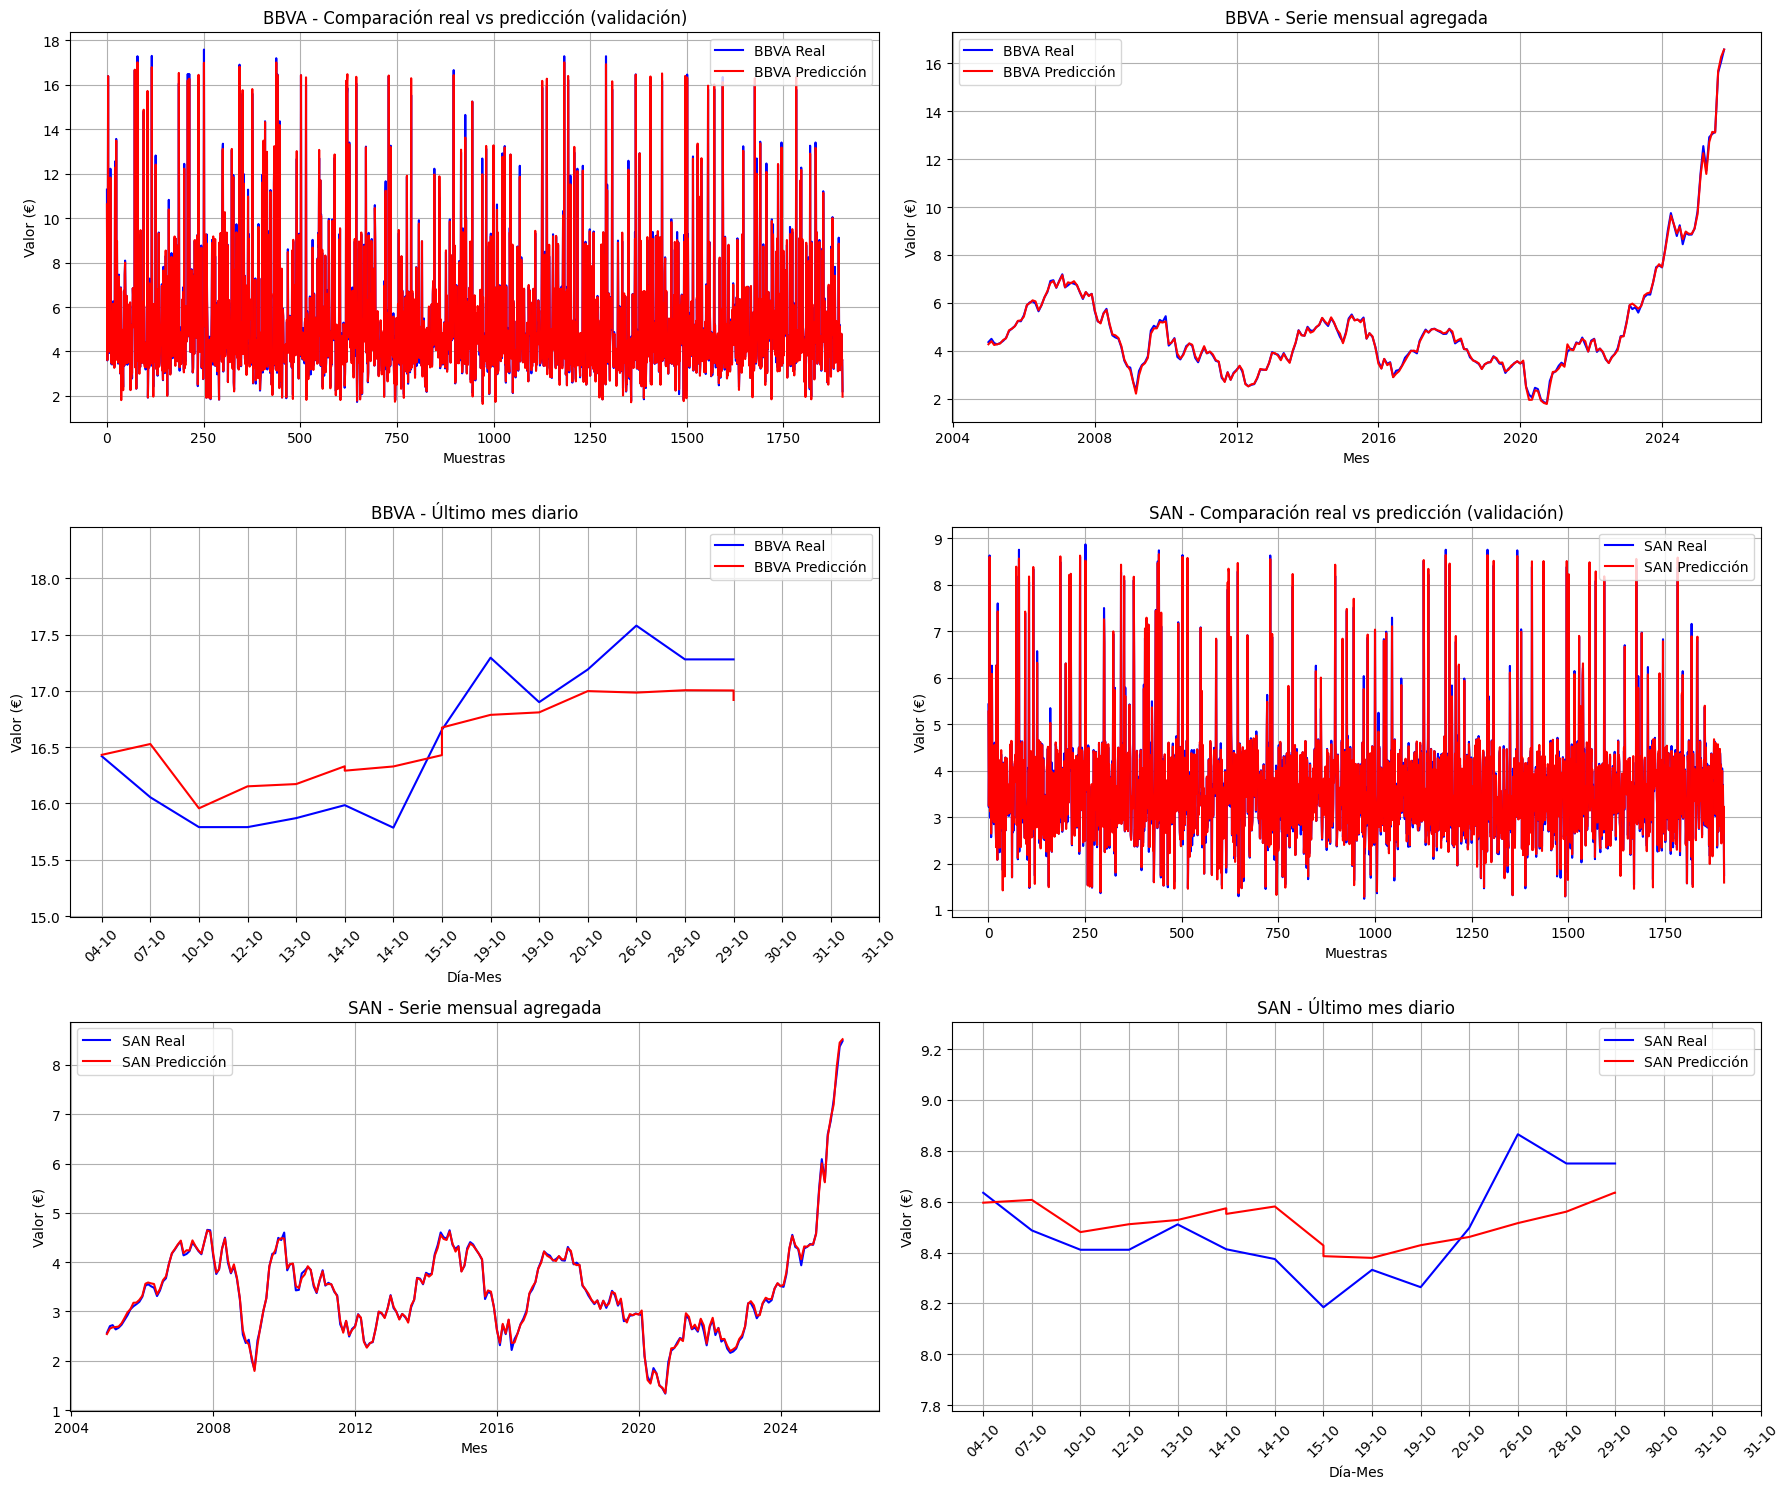

In [90]:
# ===============================
# PREDICCIÓN Y GRAFICOS CORREGIDOS
# ===============================

# ------------------------------
# 1️⃣ Predicción
# ------------------------------
y_pred = model.predict(X_val)  # shape: (samples, 2)

# ------------------------------
# 2️⃣ Función para invertir el escalado correctamente
# ------------------------------
import numpy as np

def inverse_y(scaled_y, scaler, n_features_total, target_indices=[0,1]):
    """
    scaled_y: array (samples, n_targets)
    scaler: StandardScaler que se usó para data_rnn completa
    n_features_total: total de columnas de data_rnn
    target_indices: indices de las columnas objetivo dentro de data_rnn
    """
    n_samples = scaled_y.shape[0]
    temp = np.zeros((n_samples, n_features_total))
    # Poner las predicciones en las columnas correctas
    for i, idx in enumerate(target_indices):
        temp[:, idx] = scaled_y[:, i]
    # Invertir escalado
    inv = scaler.inverse_transform(temp)
    # Devolver solo las columnas objetivo
    return inv[:, target_indices]

# ------------------------------
# 3️⃣ Aplicar inverso
# ------------------------------
n_features_total = data_scaled.shape[1]  # número total de columnas en data_rnn
target_cols = ['BBVA.MC_Close','SAN.MC_Close']
target_indices = [data_rnn.columns.get_loc(c) for c in target_cols]

y_val_inv  = inverse_y(y_val, scaler, n_features_total, target_indices)
y_pred_inv = inverse_y(y_pred, scaler, n_features_total, target_indices)

# -------------------------------
# 4️⃣ Crear DataFrames con valores reales y predichos
# -------------------------------
df_val_bbva = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,0],  # BBVA
    'y_pred': y_pred_inv[:,0]
})

df_val_san = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,1],  # SAN
    'y_pred': y_pred_inv[:,1]
})

# Agregar columna 'month' para series mensuales
df_val_bbva['month'] = df_val_bbva['date'].dt.to_period('M')
df_val_san['month'] = df_val_san['date'].dt.to_period('M')

# ------------------------------
# 5️⃣ Crear 6 gráficos (3 BBVA + 3 SAN) usando subplots
# ------------------------------
import matplotlib.pyplot as plt

assets = ['BBVA', 'SAN']
dfs = [df_val_bbva, df_val_san]

fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

for i, (asset, df) in enumerate(zip(assets, dfs)):
    # 1️⃣ Gráfico general: todo el periodo
    ax = axes[i*3]
    ax.plot(df['y_real'], label=f'{asset} Real', color='blue')
    ax.plot(df['y_pred'], label=f'{asset} Predicción', color='red')
    ax.set_title(f'{asset} - Comparación real vs predicción (validación)')
    ax.set_xlabel('Muestras')
    ax.set_ylabel('Valor (€)')
    ax.legend()
    ax.grid(True)
    
    # 2️⃣ Serie mensual agregada
    ax = axes[i*3+1]
    df_monthly = df.groupby('month').mean()
    ax.plot(df_monthly.index.to_timestamp(), df_monthly['y_real'], label=f'{asset} Real', color='blue')
    ax.plot(df_monthly.index.to_timestamp(), df_monthly['y_pred'], label=f'{asset} Predicción', color='red')
    ax.set_title(f'{asset} - Serie mensual agregada')
    ax.set_xlabel('Mes')
    ax.set_ylabel('Valor (€)')
    ax.legend()
    ax.grid(True)
    
    # 3️⃣ Último mes (diario)
    ax = axes[i*3+2]
    last_month = df['month'].max()
    df_last = df[df['month'] == last_month].sort_values('date')
    dates_plot = df_last['date'].dt.strftime('%d-%m')
    ax.plot(dates_plot, df_last['y_real'], label=f'{asset} Real', color='blue')
    ax.plot(dates_plot, df_last['y_pred'], label=f'{asset} Predicción', color='red')
    ax.set_title(f'{asset} - Último mes diario')
    ax.set_xlabel('Día-Mes')
    ax.set_ylabel('Valor (€)')
    ax.set_xticks(range(0, len(dates_plot), max(1,len(dates_plot)//10)))  # cada ~10 días
    ax.set_xticklabels(dates_plot[::max(1,len(dates_plot)//10)], rotation=45)
    ax.set_ylim(df_last[['y_real','y_pred']].min().min()*0.95, df_last[['y_real','y_pred']].max().max()*1.05)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## intento arreglar pequeñas diferencias

ValueError: cannot reindex on an axis with duplicate labels

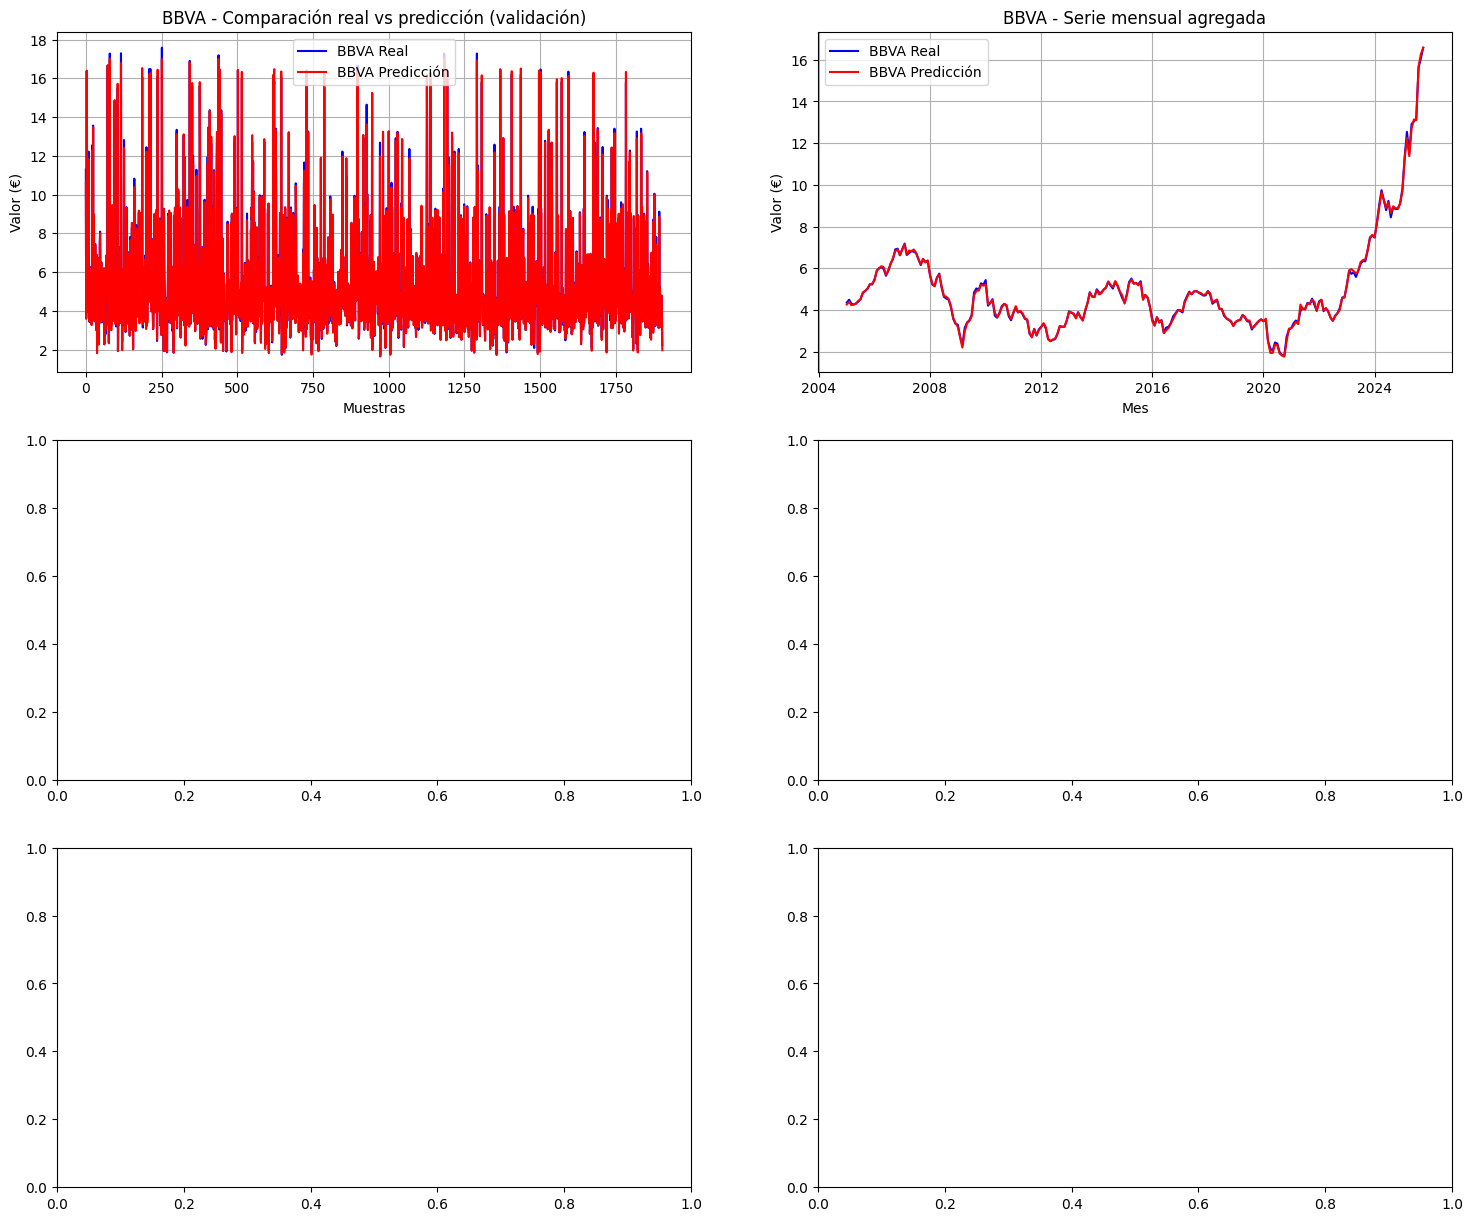

In [91]:
# ===============================
# 6 GRAFICOS MEJORADOS: BBVA y SAN
# ===============================

assets = ['BBVA', 'SAN']
dfs = [df_val_bbva, df_val_san]

fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

for col_idx, (asset, df) in enumerate(zip(assets, dfs)):
    # 1️⃣ Gráfico general: todo el periodo
    ax = axes[col_idx*3]
    ax.plot(df['y_real'].values, label=f'{asset} Real', color='blue')
    ax.plot(df['y_pred'].values, label=f'{asset} Predicción', color='red')
    ax.set_title(f'{asset} - Comparación real vs predicción (validación)')
    ax.set_xlabel('Muestras')
    ax.set_ylabel('Valor (€)')
    ax.legend()
    ax.grid(True)
    
    # 2️⃣ Serie mensual agregada
    ax = axes[col_idx*3+1]
    df_monthly = df.groupby('month').mean()
    ax.plot(df_monthly.index.to_timestamp(), df_monthly['y_real'], label=f'{asset} Real', color='blue')
    ax.plot(df_monthly.index.to_timestamp(), df_monthly['y_pred'], label=f'{asset} Predicción', color='red')
    ax.set_title(f'{asset} - Serie mensual agregada')
    ax.set_xlabel('Mes')
    ax.set_ylabel('Valor (€)')
    ax.legend()
    ax.grid(True)
    
    # 3️⃣ Último mes diario
    ax = axes[col_idx*3+2]
    last_month = df['month'].max()
    df_last = df[df['month'] == last_month].sort_values('date')
    
    # Crear índice completo del último mes
    full_dates = pd.date_range(start=df_last['date'].min(), end=df_last['date'].max(), freq='D')
    df_last_full = df_last.set_index('date').reindex(full_dates).interpolate().reset_index()
    df_last_full.rename(columns={'index':'date'}, inplace=True)
    
    dates_plot = df_last_full['date'].dt.strftime('%d-%m')
    ax.plot(dates_plot, df_last_full['y_real'].values, label=f'{asset} Real', color='blue')
    ax.plot(dates_plot, df_last_full['y_pred'].values, label=f'{asset} Predicción', color='red')
    ax.set_title(f'{asset} - Último mes diario')
    ax.set_xlabel('Día-Mes')
    ax.set_ylabel('Valor (€)')
    
    # Mostrar 10 ticks distribuidos uniformemente
    step = max(1, len(dates_plot)//10)
    ax.set_xticks(range(0, len(dates_plot), step))
    ax.set_xticklabels(dates_plot[::step], rotation=45)
    
    # Ajustar límites Y un poco por encima y debajo de los valores
    y_min = df_last_full[['y_real','y_pred']].min().min() * 0.995
    y_max = df_last_full[['y_real','y_pred']].max().max() * 1.005
    ax.set_ylim(y_min, y_max)
    
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
last_month = df_val_bbva['month'].max()  # Último mes del dataset

df_last_bbva = df_val_bbva[df_val_bbva['month'] == last_month].copy()
df_last_san  = df_val_san[df_val_san['month'] == last_month].copy()

# ------------------------------
# Mostrar todo el DataFrame
# ------------------------------
display(df_last_bbva)


In [ ]:
display(df_last_san)

In [92]:
df_last_full = pd.DataFrame({
    'date': df_last_bbva['date'],
    'BBVA_real': df_last_bbva['y_real'],
    'BBVA_pred': df_last_bbva['y_pred'],
    'SAN_real': df_last_san['y_real'],
    'SAN_pred': df_last_san['y_pred']
})

display(df_last_full)


,date,BBVA_real,BBVA_pred,SAN_real,SAN_pred
502,2025-10-04,16.420000,16.431948,8.634984,8.595918
186,2025-10-07,16.055000,16.528512,8.486905,8.606951
1555,2025-10-10,15.790000,15.957124,8.410892,8.480357
1307,2025-10-12,15.790000,16.152312,8.410892,8.511344
1126,2025-10-13,15.870000,16.172438,8.510598,8.527913
515,2025-10-14,15.985000,16.330385,8.412866,8.573963
1676,2025-10-14,15.985000,16.291387,8.412866,8.551883
1783,2025-10-15,15.785000,16.328836,8.374365,8.581054
897,2025-10-19,16.655001,16.429488,8.184824,8.427700
72,2025-10-19,16.655001,16.674549,8.184824,8.385692


In [ ]:
# ------------------------------
# Filtrar último mes
# ------------------------------
last_month = df_val_bbva['month'].max()

df_last_bbva = df_val_bbva[df_val_bbva['month'] == last_month].copy()
df_last_san  = df_val_san[df_val_san['month'] == last_month].copy()


# ------------------------------
# Crear un DataFrame final conjunto sin generar fechas inventadas
# ------------------------------
df_last_full = pd.DataFrame({
    'date': df_last_bbva['date'],  # solo los días que existen
    'BBVA_real': df_last_bbva['y_real'],
    'BBVA_pred': df_last_bbva['y_pred'],
    'SAN_real': df_last_san['y_real'].values,  # asegurar que tenga el mismo tamaño
    'SAN_pred': df_last_san['y_pred'].values
})

# ------------------------------
# Mostrar el DataFrame final del último mes
# ------------------------------
display(df_last_full)
